
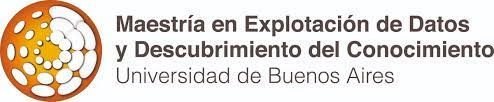

# **_Data mining en Ciencia y Tecnología_**

# **_Clustering de Imágenes_**

# Carga de librerias

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import silhouette_samples, silhouette_score
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import seaborn as sns
import plotly.express as px
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from scipy.signal import argrelextrema
from tqdm import tqdm
from sklearn.manifold import TSNE, MDS, Isomap
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix, adjusted_rand_score


DIR = "/home/economatica/MCD-CyT"

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image  # Importante para manejar imágenes

DIR = "/home/economatica/MCD-CyT/natural_images"

# Inicializamos el resumen
resumen = []

# Obtenemos solo archivos con extensiones de imagen válidas
extensiones_validas = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [os.path.join(DIR, fname) for fname in os.listdir(DIR) if fname.lower().endswith(extensiones_validas)]

# Iteramos sobre cada imagen
for idx, path in enumerate(image_files):
    try:
        img = Image.open(path)
        img_array = np.array(img)

        # Tamaño y canales
        shape = img_array.shape
        height = shape[0]
        width = shape[1]
        channels = 1 if len(shape) == 2 else shape[2]

        # Tipo y rango
        dtype = img_array.dtype
        valor_min = img_array.min()
        valor_max = img_array.max()

        resumen.append({
            'Nombre': os.path.basename(path),
            'Índice': idx,
            'Tamaño': f"{width}x{height}",
            'Canales': channels,
            'Tipo de dato': str(dtype),
            'Mínimo': valor_min,
            'Máximo': valor_max
        })

    except Exception as e:
        print(f"Error con imagen {path}: {e}")

# Validamos si hubo resultados
if not resumen:
    print("No se pudo generar ningún resumen. Revisa si el directorio contiene imágenes válidas.")
else:
    df_resumen = pd.DataFrame(resumen)

    columnas_necesarias = {'Tamaño', 'Canales', 'Tipo de dato'}
    if columnas_necesarias.issubset(df_resumen.columns):
        tabla_rango = df_resumen.groupby(['Tamaño', 'Canales', 'Tipo de dato']).agg(
            Cantidad=('Nombre', 'count'),
            Mínimo_global=('Mínimo', 'min'),
            Máximo_global=('Máximo', 'max')
        ).reset_index()

        print("\nTabla de resumen agrupado:")
        print(tabla_rango)
    else:
        print("No se encontraron todas las columnas necesarias para agrupar.")



📊 Tabla de resumen agrupado:
        Tamaño  Canales Tipo de dato  Cantidad  Mínimo_global  Máximo_global
0     1000x460        3        uint8         1              0            255
1     1000x667        3        uint8         1             10            255
2     1000x684        3        uint8         1              0            255
3     1001x748        3        uint8         1              0            255
4      100x100        3        uint8      1968              0            255
...        ...      ...          ...       ...            ...            ...
3597   993x643        3        uint8         1              0            255
3598   993x775        3        uint8         1              3            255
3599   996x714        3        uint8         1              0            255
3600   996x747        3        uint8         1              0            255
3601    99x136        3        uint8         1              0            255

[3602 rows x 6 columns]


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definición de funciones útiles

In [2]:
def preprocess_and_extract(file_list, model):
    images = []
    for file in file_list:
        img = load_img(file, target_size=(224, 224))
        img = img_to_array(img)
        images.append(img)

    # Convertir a array y preprocesar todo junto
    images = np.array(images)
    images = preprocess_input(images)

    # Predecir todas las imágenes en batch
    features = model.predict(images, batch_size=32, verbose=1)
    return np.array(file_list), features

def view_cluster(gps, cluster):
    plt.figure(figsize=(25, 25))
    files = gps
    # Máximo 10 para visualizar
    if len(files) > 10:
        files = files[:10]
    for index, file in enumerate(files):
        plt.subplot(1, 10, index + 1)
        img = load_img(file)
        img = img_to_array(img).astype('uint8')
        plt.imshow(img)
        plt.title(f'Cluster n: {cluster}')
        plt.axis('off')
    plt.show()

def plot_silhouette(X, labels):
    silhouette_vals = silhouette_samples(X, labels)
    silhouette_avg = silhouette_score(X, labels)
    n_clusters = len(np.unique(labels))

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = silhouette_vals[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette Plot (sin Yellowbrick)")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

# === Función para índice de van Dongen ===
def van_dongen_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    max_rows = np.max(cm, axis=1)
    max_cols = np.max(cm, axis=0)
    vd = 1 - ((np.sum(max_rows) + np.sum(max_cols)) / (2 * np.sum(cm)))
    return vd


# Extracción de features de imágenes con la red neuronal VGG16

Definimos un modelo VGG16 utilizando la arquitectura provista por Keras.

Esta trae por defecto los pesos entrenados con ImageNet (ver https://keras.io/api/applications/vgg/).

Luego vamos a redefinir la arquitectura utilizando hasta la anteúltima capa.
Existen diversas formas de hacer esto pero una sencilla en este caso es utilizar un Model genérico y pasarle el input y output del modelo anterior.

Podemos tomar cualquier punto del proceso como output accediendo a la lista de layers y devolviendo la propiedad "output" de esa capa.

In [8]:
input_tensor = Input(shape=(224, 224, 3)) # Detalle: redefinimos el input tensor para evitar warnings al predecir

model = VGG16(input_tensor=input_tensor)
model = Model(inputs = input_tensor, outputs = model.layers[-2].output) # Salida de la anteúltima capa, antes de la clasificación

2025-06-30 14:33:54.307460: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-30 14:33:54.422125: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-30 14:33:54.496276: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


2025-06-30 14:33:54.527293: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


2025-06-30 14:33:58.339758: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


Si observamos que pasamos como output, se trata de un tensor de Keras.
Estos objetos guardan la referencia al tensor anterior, lo que permite a la librería reconstruir el grafo computacional del modelo completo.

In [9]:
model.layers[-1].output # Accedemos a la última en este caso porque ya recortamos el VGG original)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>

Observamos como queda el modelo, sin la última capa de 1000 salidas.

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

Probemos VGG16 aplicándolo al dataset de natural_images

In [16]:
image_path = f"{DIR}/natural_images"
path = sorted([os.path.join(image_path, file)
for file in os.listdir(image_path )
if file.endswith('.jpg')])

print(len(path))
print(path[0])

6899
/home/economatica/MCD-CyT/natural_images/airplane_0000.jpg


Ahora vamos a aplicar el modelo y extraer las features.

In [18]:
names, feat = preprocess_and_extract(path, model)

np.savez_compressed(f"{DIR}/features_vgg16.npz", names=names, features=feat)

2025-06-30 14:40:46.553566: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4153970688 exceeds 10% of free system memory.


216/216 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step


In [ ]:
# Veamos el tamaño de los features de la primera imagen
print('El tamaño de la imagen es ', np.array(load_img(path[0])).shape)
print('El tamaño de la imagen dada como input a VGG16 es ', np.array(load_img(path[0],target_size=(224,224))).shape)
print('El tamaño del array de features de la imagen inferido por VGG16 es ', feat[0].shape)

El tamaño de la imagen es  (104, 300, 3)
El tamaño de la imagen dada como input a VGG16 es  (224, 224, 3)
El tamaño del array de features de la imagen inferido por VGG16 es  (4096,)


# Reducción de la dimensionalidad de los features obtenidos via PCA

## Carga de datos .npz

In [3]:
data = np.load("features_vgg16.npz", allow_pickle=True)
names = data["names"]
feat = data["features"]


## Normalización de Features

In [4]:
# === NORMALIZACIÓN DE FEATURES ===
# Supone que ya tenés los features extraídos con VGG16 en la variable `feat`

print("📊 Normalizando features (Z-score)...")
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(feat)

print("✅ Normalización completada.")
print(f"- Media post-normalización (esperada ~0): {feat_scaled.mean():.4f}")
print(f"- Desviación estándar (esperada ~1): {feat_scaled.std():.4f}")

📊 Normalizando features (Z-score)...
✅ Normalización completada.
- Media post-normalización (esperada ~0): 0.0000
- Desviación estándar (esperada ~1): 0.9984


## PCA - Determinación de los componentes óptimos

Cantidad de componentes necesarias para explicar el 95% de la varianza: 1416
Cantidad de componentes necesarias para explicar el 80% de la varianza: 348
Cantidad de componentes necesarias para explicar el 75% de la varianza: 229
Cantidad de componentes necesarias para explicar el 70% de la varianza: 155


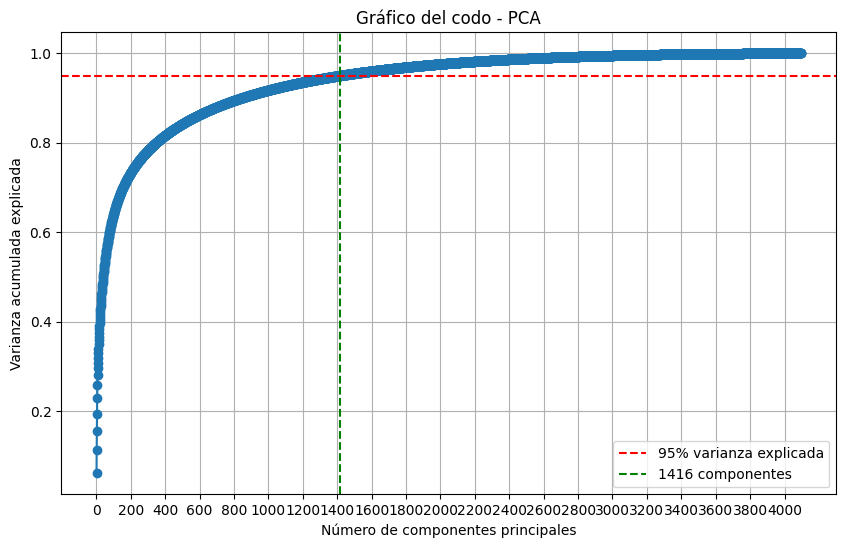

In [5]:
X = feat_scaled
# PCA sin reducción para conocer la varianza explicada acumulada
pca = PCA()
X_pca = pca.fit_transform(X)

# Varianza acumulada
var_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Número de componentes que explican al menos el 95%
n_componentes_95 = np.argmax(var_acumulada >= 0.95) + 1
print(f"Cantidad de componentes necesarias para explicar el 95% de la varianza: {n_componentes_95}")

# Número de componentes que explican al menos el 80%%
n_componentes_80 = np.argmax(var_acumulada >= 0.80) + 1
print(f"Cantidad de componentes necesarias para explicar el 80% de la varianza: {n_componentes_80}")

# Número de componentes que explican al menos el 80%%
n_componentes_75 = np.argmax(var_acumulada >= 0.75) + 1
print(f"Cantidad de componentes necesarias para explicar el 75% de la varianza: {n_componentes_75}")

# Número de componentes que explican al menos el 80%%
n_componentes_70 = np.argmax(var_acumulada >= 0.70) + 1
print(f"Cantidad de componentes necesarias para explicar el 70% de la varianza: {n_componentes_70}")

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_acumulada) + 1), var_acumulada, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza explicada')
plt.axvline(x=n_componentes_95, color='g', linestyle='--', label=f'{n_componentes_95} componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Gráfico del codo - PCA')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, len(var_acumulada) + 1, 200))
plt.show()


## PCA Reducido

In [6]:
# Reducción real a solo los componentes necesarios
pca_reducido = PCA(n_components=n_componentes_70)
X_pca_reducido = pca_reducido.fit_transform(feat_scaled)

print(f"Reduced to {pca_reducido.n_components_} components (explains ≥70% of variance)")
print(f"Components before PCA: {feat_scaled.shape[1]}")
print(f"Components after PCA: {pca_reducido.n_components_}")


Reduced to 155 components (explains ≥70% of variance)
Components before PCA: 4096
Components after PCA: 155


## Gráfica PCA 2D

In [13]:
# Leer CSV con nombres de archivo y etiquetas
df = pd.read_csv(DIR + '/natural_images_labels.csv')

# Crear diccionario: {nombre_archivo: etiqueta}
filename_to_label = dict(zip(df['file'], df['label']))




filename_to_label

{'airplane_0000.jpg': 'airplane',
 'airplane_0001.jpg': 'airplane',
 'airplane_0002.jpg': 'airplane',
 'airplane_0003.jpg': 'airplane',
 'airplane_0004.jpg': 'airplane',
 'airplane_0005.jpg': 'airplane',
 'airplane_0006.jpg': 'airplane',
 'airplane_0007.jpg': 'airplane',
 'airplane_0008.jpg': 'airplane',
 'airplane_0009.jpg': 'airplane',
 'airplane_0010.jpg': 'airplane',
 'airplane_0011.jpg': 'airplane',
 'airplane_0012.jpg': 'airplane',
 'airplane_0013.jpg': 'airplane',
 'airplane_0014.jpg': 'airplane',
 'airplane_0015.jpg': 'airplane',
 'airplane_0016.jpg': 'airplane',
 'airplane_0017.jpg': 'airplane',
 'airplane_0018.jpg': 'airplane',
 'airplane_0019.jpg': 'airplane',
 'airplane_0020.jpg': 'airplane',
 'airplane_0021.jpg': 'airplane',
 'airplane_0022.jpg': 'airplane',
 'airplane_0023.jpg': 'airplane',
 'airplane_0024.jpg': 'airplane',
 'airplane_0025.jpg': 'airplane',
 'airplane_0026.jpg': 'airplane',
 'airplane_0027.jpg': 'airplane',
 'airplane_0028.jpg': 'airplane',
 'airplane_002

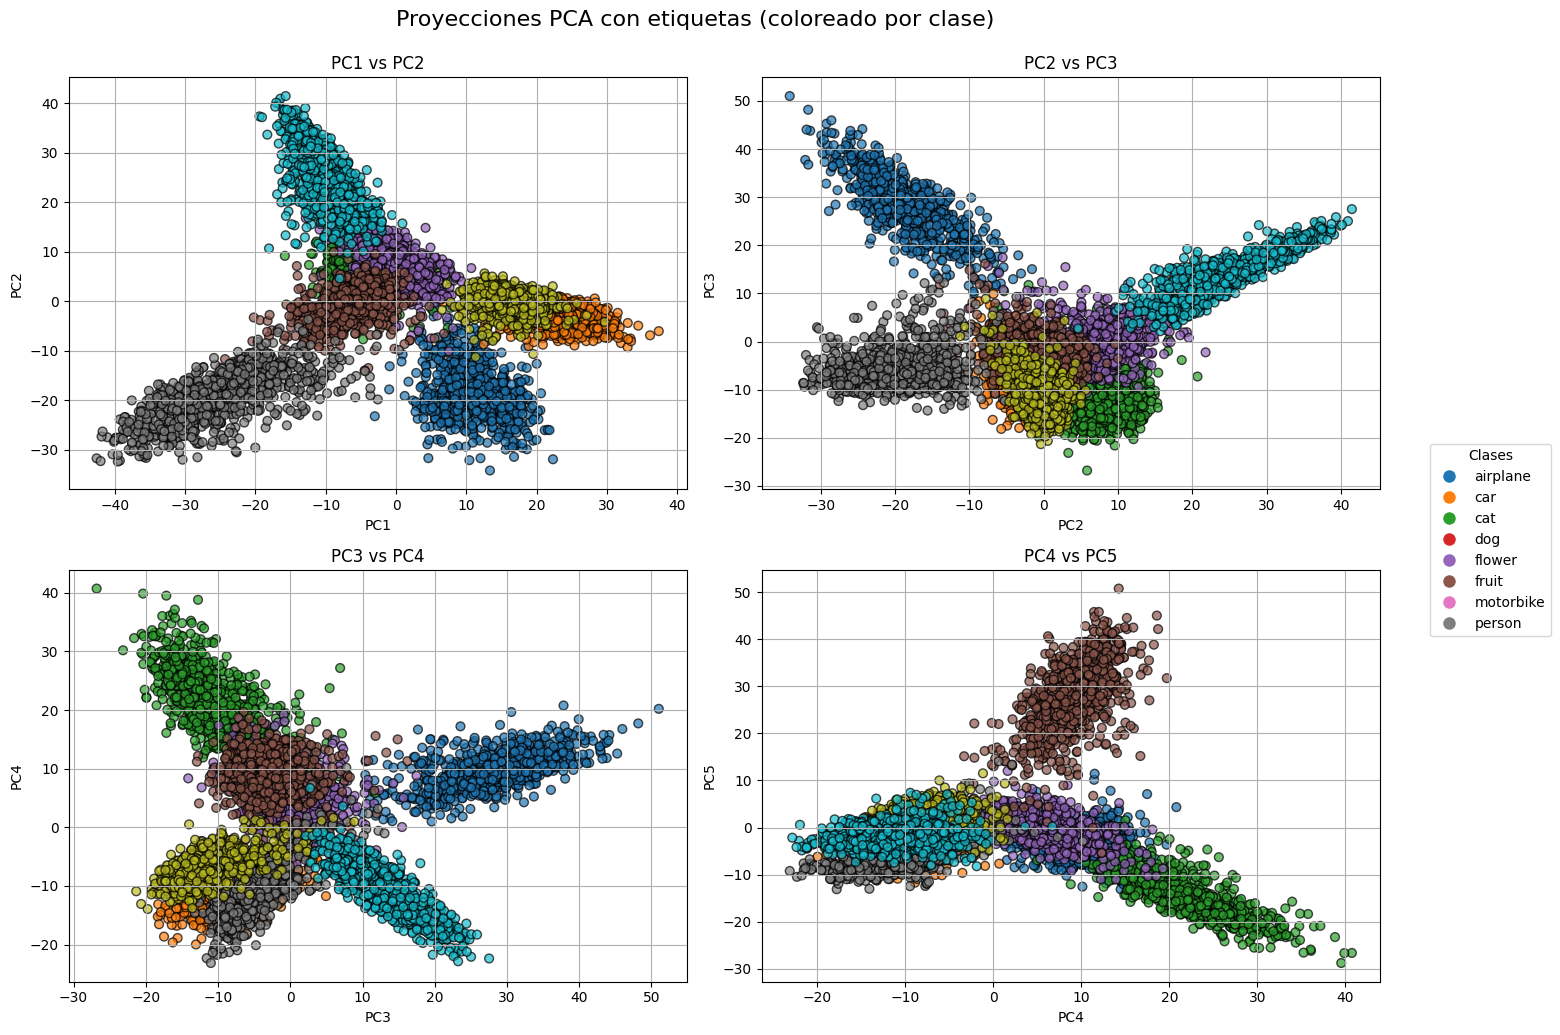

In [15]:
# Leer CSV con nombres de archivo y etiquetas
df = pd.read_csv(DIR + '/natural_images_labels.csv')

# Crear diccionario: {nombre_archivo: etiqueta}
filename_to_label = dict(zip(df['file'], df['label']))

# Alinear etiquetas con el orden de 'names' (la lista de imágenes procesadas)

label = [filename_to_label[os.path.basename(name)] for name in names]


# Codificar etiquetas numéricamente
le = LabelEncoder()
label_encoded = le.fit_transform(label)

# Obtener nombres únicos de clases (ordenados según LabelEncoder)
unique_labels = le.classes_


# Pares de componentes para graficar (PC1 vs PC2, PC2 vs PC3, etc.)
component_pairs = [(0, 1), (1, 2), (2, 3), (3, 4)]

# Crear los subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, (comp_x, comp_y) in enumerate(component_pairs):
    scatter = axes[i].scatter(
        X_pca_reducido[:, comp_x], X_pca_reducido[:, comp_y],
        c=label_encoded, cmap='tab10', alpha=0.7, edgecolor='k', s=40
    )
    axes[i].set_xlabel(f'PC{comp_x + 1}')
    axes[i].set_ylabel(f'PC{comp_y + 1}')
    axes[i].set_title(f'PC{comp_x + 1} vs PC{comp_y + 1}')
    axes[i].grid(True)

# Crear leyenda personalizada con los nombres de clase correctos
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=class_name,
           markerfacecolor=plt.cm.tab10(i),
           markersize=10)
    for i, class_name in enumerate(unique_labels)
]

# Mostrar leyenda fuera del gráfico
fig.legend(handles=legend_elements, title='Clases',
           bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.tight_layout()
plt.suptitle('Proyecciones PCA con etiquetas (coloreado por clase)', fontsize=16, y=1.03)
plt.show()


## Gráfica PCA 3D

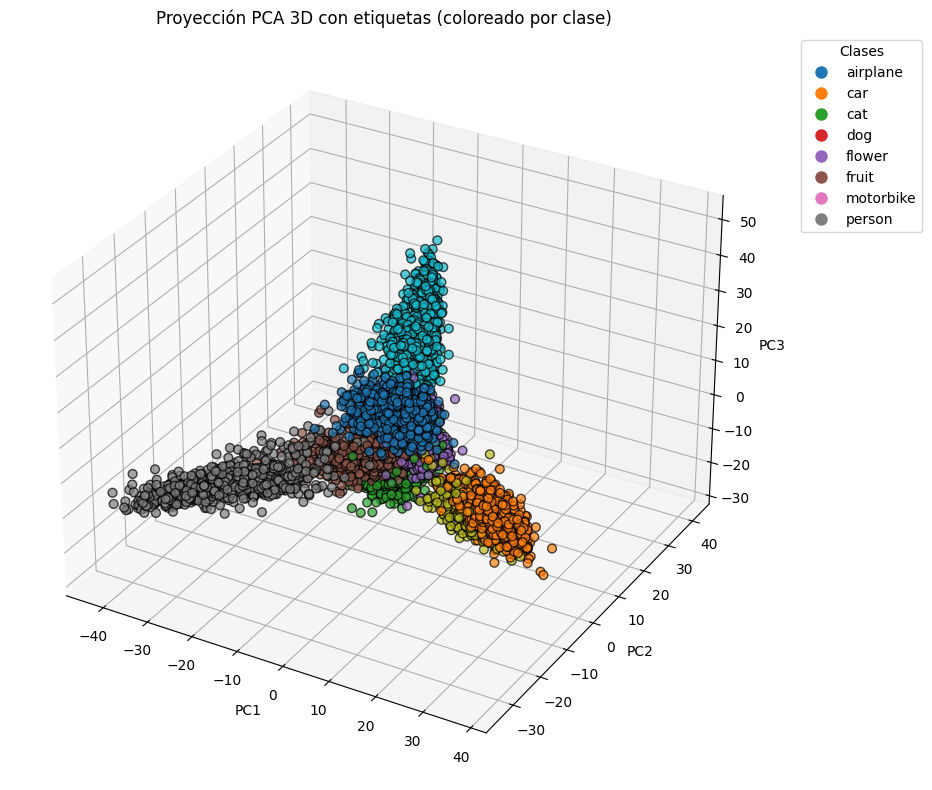

In [16]:
# Leer el archivo CSV con nombres y etiquetas
df = pd.read_csv(DIR + '/natural_images_labels.csv')

# Crear un diccionario {archivo: etiqueta}
filename_to_label = dict(zip(df['file'], df['label']))

# Obtener las etiquetas en el mismo orden que 'names'

label = [filename_to_label[os.path.basename(name)] for name in names]


# Codificar etiquetas como números (necesario para clustering o visualización)
le = LabelEncoder()
label_encoded = le.fit_transform(label)


# Aplicar PCA si aún no lo hiciste
# from sklearn.decomposition import PCA

# Crear gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_reducido[:, 0], X_pca_reducido[:, 1], X_pca_reducido[:, 2],
    c=label_encoded, cmap='tab10', alpha=0.7, edgecolor='k', s=40
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Proyección PCA 3D con etiquetas (coloreado por clase)')

# Crear leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=class_name,
                          markerfacecolor=plt.cm.tab10(i),
                          markersize=10)
                   for i, class_name in enumerate(unique_labels)]

ax.legend(handles=legend_elements, title='Clases', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


# Resumen punto 5

Resumen metodológico con justificación por diversidad de clases (versión revisada)

Para esta investigación se trabajó con un conjunto de 6.899 imágenes naturales, distribuidas en 8 categorías visualmente distintas: aviones, autos, gatos, flores, perros, frutas, motos y personas. Esta diversidad proporciona un escenario ideal para explorar representaciones visuales profundas y aplicar técnicas no supervisadas como reducción de dimensionalidad y agrupamiento.

Se empleó el modelo VGG16 preentrenado en ImageNet para la extracción de características visuales. En particular, se utilizó la capa densa fc1, que genera vectores de 4096 dimensiones por imagen. Estas representaciones condensan información abstracta de alto nivel relacionada con formas, texturas, patrones y estructuras semánticas, aprendidas a partir de millones de imágenes.

El análisis estadístico de los vectores arrojó una media global de 0.473, una desviación estándar de 1.147, y valores en el rango de 0 a 28.45. Estas diferencias de escala entre dimensiones reflejan una activación desigual entre componentes. Además, considerando la alta heterogeneidad visual entre clases —como personas frente a vehículos o animales—, se concluyó que es fundamental aplicar una normalización tipo Z-score. Esto garantiza que todas las características contribuyan equitativamente a los algoritmos posteriores, evitando que ciertas dimensiones dominen el análisis debido a diferencias de escala o activación.

Posteriormente, se aplicó Análisis de Componentes Principales (PCA) como técnica de reducción de dimensionalidad, con el objetivo de preservar la mayor parte de la información visual original, reduciendo al mismo tiempo la carga computacional. Se evaluó la varianza explicada acumulada por los componentes principales, obteniéndose los siguientes resultados:

    Para conservar el 95% de la varianza, se requerían 1.416 componentes

    Para el 80%, eran necesarios 348 componentes

    Para el 70% de la varianza, bastaban 155 componentes

Por equilibrio entre eficiencia y preservación de información significativa, se decidió reducir la dimensionalidad a 155 componentes, lo que permite representar cada imagen en un espacio más compacto y manejable, manteniendo una parte sustancial de la variabilidad original.


In [59]:
## get the unique labels (from the natural_images_label.csv)
df = pd.read_csv(DIR+'/natural_images_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))
print(unique_labels)

['airplane', 'dog', 'flower', 'car', 'person', 'motorbike', 'fruit', 'cat']


🔍 Dimensiones:
 - Número de imágenes: 6899
 - Dimensiones por imagen: 4096

📊 Estadísticas globales de los features:
 - Media global: 0.4730
 - Desviación estándar: 1.1470
 - Valor mínimo: 0.0000
 - Valor máximo: 28.4520


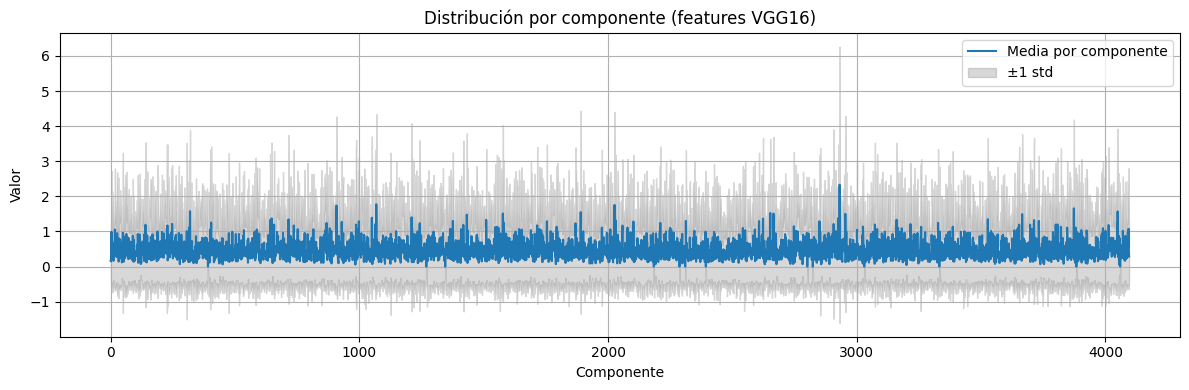

In [58]:
# feat: matriz (n_imágenes, n_features)
print("🔍 Dimensiones:")
print(f" - Número de imágenes: {feat.shape[0]}")
print(f" - Dimensiones por imagen: {feat.shape[1]}")

print("\n📊 Estadísticas globales de los features:")
print(f" - Media global: {np.mean(feat):.4f}")
print(f" - Desviación estándar: {np.std(feat):.4f}")
print(f" - Valor mínimo: {np.min(feat):.4f}")
print(f" - Valor máximo: {np.max(feat):.4f}")

# Por componente
feature_means = np.mean(feat, axis=0)
feature_stds = np.std(feat, axis=0)

# Visualización
plt.figure(figsize=(12, 4))
plt.plot(feature_means, label="Media por componente")
plt.fill_between(range(len(feature_means)),
                 feature_means - feature_stds,
                 feature_means + feature_stds,
                 color='gray', alpha=0.3, label='±1 std')
plt.title("Distribución por componente (features VGG16)")
plt.xlabel("Componente")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Clustering por prótotipos - K-Means

🔍 Máximos locales de Silhouette:
k = 7 → Silhouette Score = 0.1595
k = 9 → Silhouette Score = 0.1588
k = 11 → Silhouette Score = 0.1585
k = 17 → Silhouette Score = 0.1127
k = 19 → Silhouette Score = 0.1109
k = 21 → Silhouette Score = 0.0978
k = 23 → Silhouette Score = 0.0963
k = 26 → Silhouette Score = 0.0940
k = 28 → Silhouette Score = 0.0939
k = 32 → Silhouette Score = 0.0952
k = 35 → Silhouette Score = 0.0967
k = 39 → Silhouette Score = 0.0891
k = 45 → Silhouette Score = 0.0935


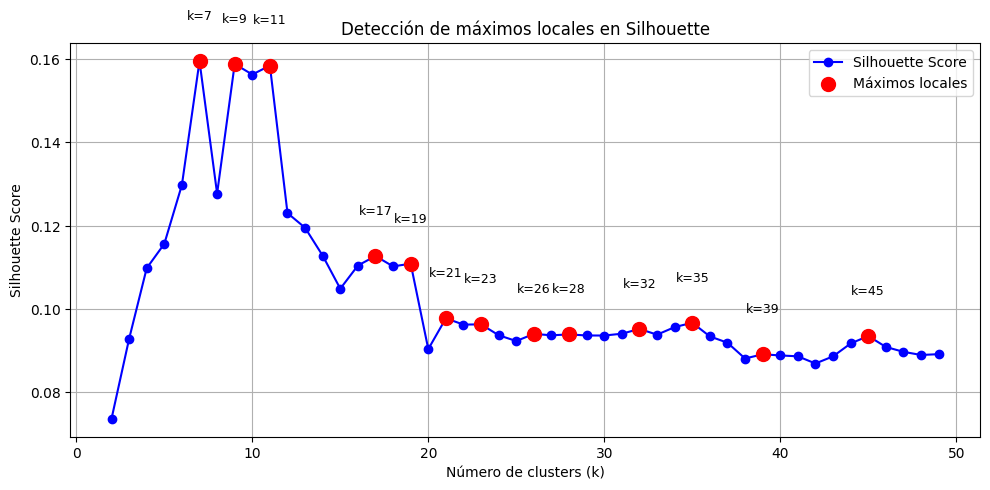

In [ ]:
# === 1. Rango de k y datos ===
k_range = list(range(2, 50))
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca_reducido)  # Asegurate de tener esta variable
    score = silhouette_score(X_pca_reducido, labels)
    silhouette_scores.append(score)

# === 2. Convertir a array para detección de máximos locales ===
scores_array = np.array(silhouette_scores)
local_maxima_idx = argrelextrema(scores_array, np.greater)[0]

# === 3. Mostrar valores detectados ===
print("🔍 Máximos locales de Silhouette:")
for idx in local_maxima_idx:
    print(f"k = {k_range[idx]} → Silhouette Score = {scores_array[idx]:.4f}")

# === 4. Gráfico ===
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', label='Silhouette Score', color='blue')

# Marcar los máximos locales
max_k_values = [k_range[i] for i in local_maxima_idx]
max_scores = [silhouette_scores[i] for i in local_maxima_idx]
plt.scatter(max_k_values, max_scores, color='red', s=100, label='Máximos locales', zorder=5)

# Anotar en el gráfico
for x, y in zip(max_k_values, max_scores):
    plt.text(x, y + 0.01, f'k={x}', ha='center', fontsize=9)

plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Detección de máximos locales en Silhouette")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




🔍 Mínimos locales de SSE (posibles codos):
k = 7 → SSE = 13264057.00


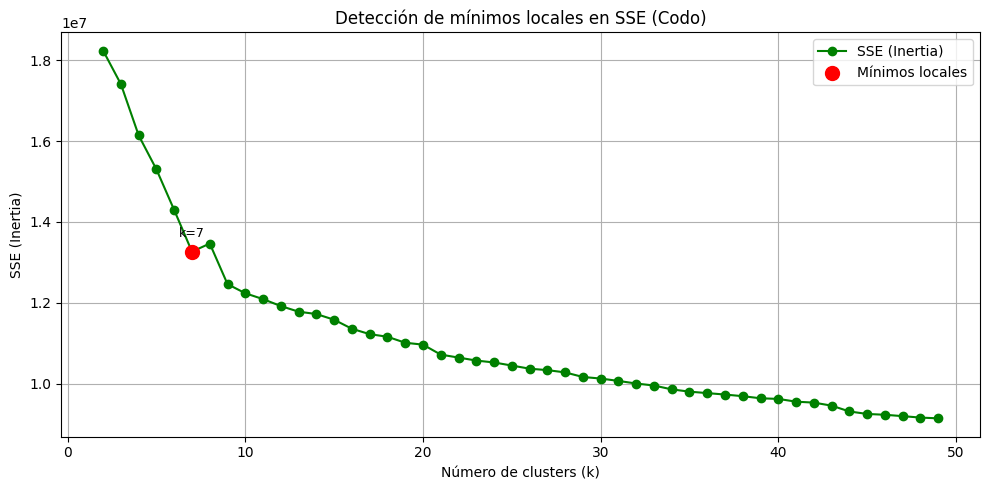

In [92]:
# === 1. Rango de k y datos ===
k_range = list(range(2, 50))
sse_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_pca_reducido)  # Asegúrate de tener esta variable lista
    sse = kmeans.inertia_
    sse_scores.append(sse)

# === 2. Convertir a array para detección de mínimos locales ===
sse_array = np.array(sse_scores)
local_minima_idx = argrelextrema(sse_array, np.less)[0]

# === 3. Mostrar valores detectados ===
print("🔍 Mínimos locales de SSE (posibles codos):")
for idx in local_minima_idx:
    print(f"k = {k_range[idx]} → SSE = {sse_array[idx]:.2f}")

# === 4. Gráfico ===
plt.figure(figsize=(10, 5))
plt.plot(k_range, sse_scores, marker='o', label='SSE (Inertia)', color='green')

# Marcar los mínimos locales
min_k_values = [k_range[i] for i in local_minima_idx]
min_sse_values = [sse_scores[i] for i in local_minima_idx]
plt.scatter(min_k_values, min_sse_values, color='red', s=100, label='Mínimos locales', zorder=5)

# Anotar en el gráfico
for x, y in zip(min_k_values, min_sse_values):
    plt.text(x, y + (max(sse_scores)*0.02), f'k={x}', ha='center', fontsize=9)

plt.xlabel("Número de clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Detección de mínimos locales en SSE (Codo)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔁 Ejecutando bootstrapping por cada valor de k...



KMeans Bootstrapping: 100%|██████████| 15/15 [1:21:49<00:00, 327.27s/it]



📊 Tabla resumen (Silhouette & SSE):

 k  silhouette_mean  silhouette_std      sse_mean     sse_std
 2           0.0787          0.0276 18513296.1000 229020.7174
 3           0.0804          0.0214 17376571.2500 251301.7037
 4           0.0934          0.0192 16322651.7060 321846.8243
 5           0.1121          0.0172 15329635.3840 356152.1431
 6           0.1286          0.0188 14502203.9900 427357.8625
 7           0.1437          0.0215 13763950.7220 470525.2268
 8           0.1546          0.0224 13072519.6540 427061.3057
 9           0.1573          0.0215 12663256.0700 357470.3219
10           0.1562          0.0185 12346426.7860 278597.7151
11           0.1501          0.0195 12130191.1620 220444.5384
12           0.1438          0.0204 11947626.3120 175388.3986
13           0.1388          0.0206 11780520.3220 145673.0204
14           0.1321          0.0197 11634909.8380 130036.9878
15           0.1271          0.0183 11502970.7540 143393.9048
16           0.1236          0.0

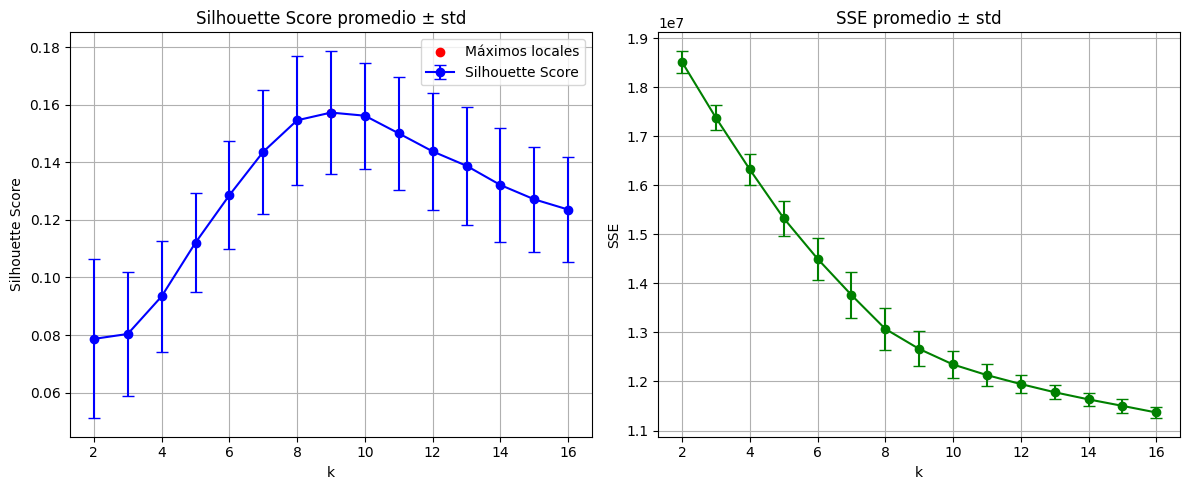

In [93]:
# === Usa tu matriz PCA reducida ===
X = X_pca_reducido  # Asegúrate de tener esta variable

# === Parámetros ===
k_values = list(range(2, 17))  # k de 2 a 16
n_bootstrap = 500  # cantidad de repeticiones

# === Guardar resultados ===
results = {
    'k': [],
    'silhouette_mean': [],
    'silhouette_std': [],
    'sse_mean': [],
    'sse_std': []
}

tqdm.write("🔁 Ejecutando bootstrapping por cada valor de k...\n")

# === Loop principal ===
for k in tqdm(k_values, desc="KMeans Bootstrapping"):
    sil_scores = []
    sse_scores = []
    
    for _ in range(n_bootstrap):
        # 1. Muestra aleatoria con reemplazo
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_sample = X[indices]

        # 2. KMeans con k fijo
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=None)
        labels = kmeans.fit_predict(X_sample)

        # 3. Calcular métricas
        sil = silhouette_score(X_sample, labels)
        sse = kmeans.inertia_

        sil_scores.append(sil)
        sse_scores.append(sse)

    # 4. Guardar promedios y desviaciones
    results['k'].append(k)
    results['silhouette_mean'].append(np.mean(sil_scores))
    results['silhouette_std'].append(np.std(sil_scores))
    results['sse_mean'].append(np.mean(sse_scores))
    results['sse_std'].append(np.std(sse_scores))

# === Convertir a DataFrame
df_results = pd.DataFrame(results)

# === Detectar máximos locales en Silhouette
silhouette_array = df_results['silhouette_mean'].values
local_max_idx = argrelextrema(silhouette_array, np.greater)[0]
local_max_k = df_results.iloc[local_max_idx]['k'].values

# === Mostrar tabla resumen
print("\n📊 Tabla resumen (Silhouette & SSE):\n")
print(df_results.to_string(index=False, float_format="%.4f"))

# === Mostrar máximos locales
print("\n🔍 Máximos locales en Silhouette Score:")
for k in local_max_k:
    row = df_results[df_results['k'] == k].iloc[0]
    print(f"  k = {int(k)} → Silhouette = {row['silhouette_mean']:.4f} ± {row['silhouette_std']:.4f}")

# === Graficar resultados
plt.figure(figsize=(12, 5))

# Silhouette
plt.subplot(1, 2, 1)
plt.errorbar(df_results['k'], df_results['silhouette_mean'], yerr=df_results['silhouette_std'],
             fmt='-o', capsize=4, label='Silhouette Score', color='blue')
plt.scatter(local_max_k,
            df_results[df_results['k'].isin(local_max_k)]['silhouette_mean'],
            color='red', label='Máximos locales')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score promedio ± std')
plt.legend()
plt.grid(True)

# SSE
plt.subplot(1, 2, 2)
plt.errorbar(df_results['k'], df_results['sse_mean'], yerr=df_results['sse_std'],
             fmt='-o', capsize=4, label='SSE (inercia)', color='green')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('SSE promedio ± std')
plt.grid(True)

plt.tight_layout()
plt.show()


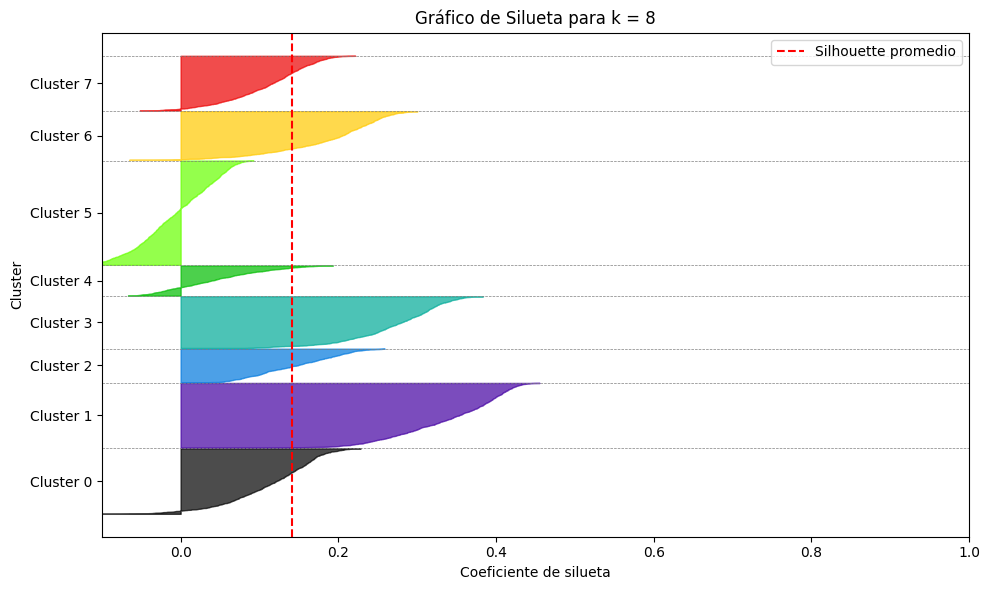

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# === Parámetro ===
k = 8  # Cambiá esto por el k óptimo

# === Aplicar KMeans ===
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_pca_reducido)

# === Cálculo de siluetas ===
silhouette_avg = silhouette_score(X_pca_reducido, cluster_labels)
sample_silhouette_values = silhouette_samples(X_pca_reducido, cluster_labels)

# === Gráfico ===
fig, ax1 = plt.subplots(figsize=(10, 6))

y_lower = 10
ytick_positions = []

for i in range(k):
    # Extraer valores de silueta para el cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Guardar posición media del cluster para etiquetar luego
    ytick_positions.append((y_lower + y_upper) / 2)

    # Línea horizontal para separar clusters
    ax1.hlines(y=y_upper, xmin=-0.1, xmax=1.0, color='gray', linestyle='--', linewidth=0.5)

    y_lower = y_upper + 10  # Espacio entre clusters

# === Línea vertical del promedio ===
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Silhouette promedio")

# === Etiquetas y formato ===
ax1.set_title(f"Gráfico de Silueta para k = {k}")
ax1.set_xlabel("Coeficiente de silueta")
ax1.set_ylabel("Cluster")

# Etiquetas en el eje Y
ax1.set_yticks(ytick_positions)
ax1.set_yticklabels([f'Cluster {i}' for i in range(k)])

ax1.set_xlim([-0.1, 1])
ax1.legend(loc='best')
plt.tight_layout()
plt.show()



Se aplicó el algoritmo K-Means sobre el conjunto de atributos extraídos mediante VGG16 y reducidos dimensionalmente mediante PCA. Para determinar el número óptimo de clusters, se utilizaron dos métricas clave: el Silhouette Score y la Suma de Errores Cuadrados (SSE).

Con el fin de obtener estimaciones más robustas y confiables, se implementó un procedimiento de validación mediante bootstrap con 500 repeticiones, evaluando cada valor de kk en el rango de 2 a 15. En cada iteración, se calculó el Silhouette Score y la SSE, permitiendo obtener la media y desviación estándar de ambas métricas para cada kk.

El análisis conjunto de estas métricas mostró que el valor k=7k=7 representa el mejor equilibrio entre compacidad y separación de los clusters. Este valor corresponde a:

    Un máximo local en el Silhouette Score (media = 0.1595), indicando buena cohesión intra-cluster y separación inter-cluster.

    Un mínimo local en la curva de SSE, señalando un punto de estabilización o “codo” en la mejora de compactación.

Por estas razones, se seleccionó k=7k=7 como el número óptimo de clusters para representar la estructura subyacente de los datos.

Cabe destacar que, si bien el conjunto de datos incluye 8 clases reales, el modelo no supervisado sugirió que 7 clusters es suficiente para capturar la estructura más representativa de los datos. Esta diferencia puede deberse a clases visualmente similares o a la presencia de outliers, que influyen en la formación de agrupamientos durante el proceso no supervisado.

### Vizualizacion

Reduciendo con PCA...
Reduciendo con t-SNE (perp=50)...


Reduciendo con MDS...


/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Reduciendo con Isomap (n=10)...


/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr

Reduciendo con UMAP (n=15)...


/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


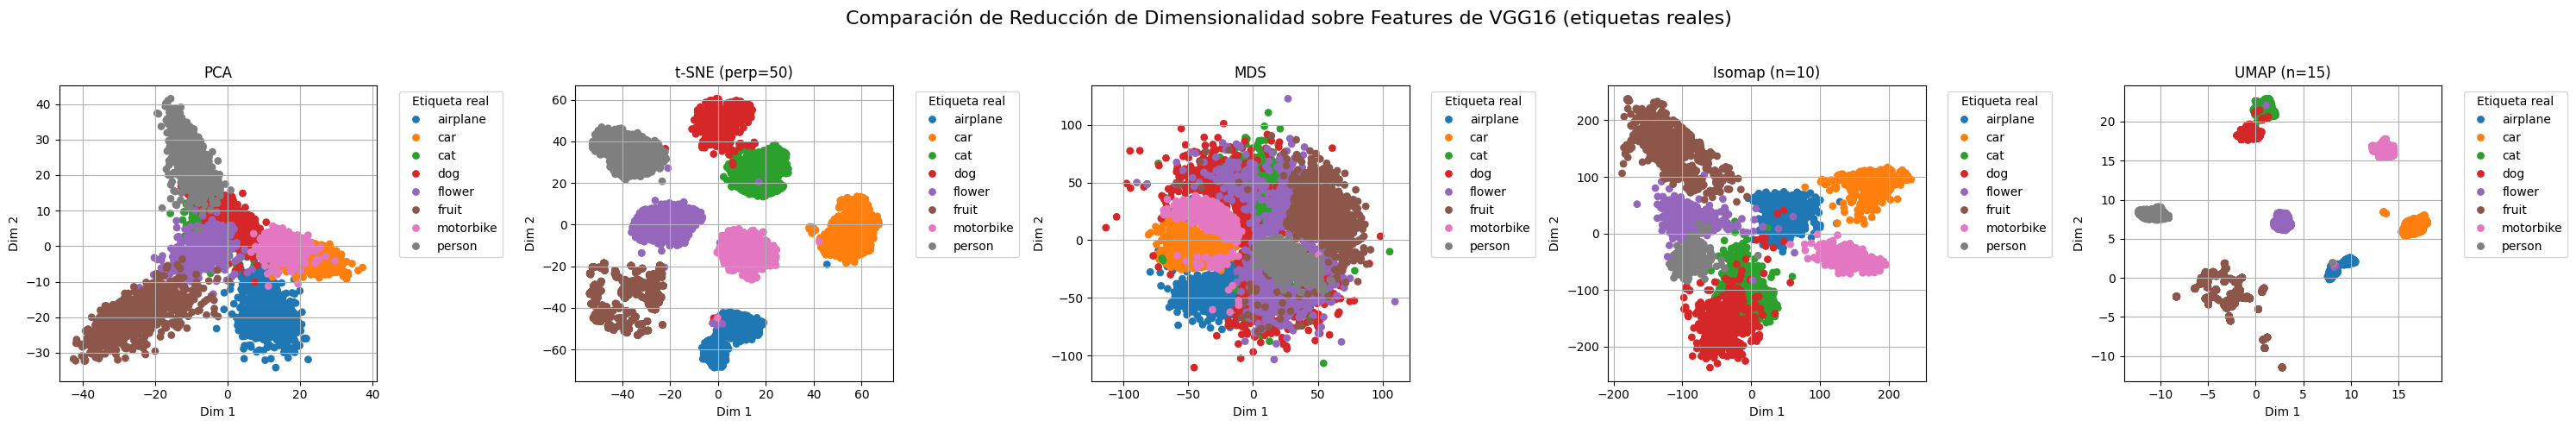

In [116]:
# === 1. Cargar etiquetas reales ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
y_true = df['label'].tolist()

# === 2. Usar features ya reducidos con PCA (ej: 50D) como base ===
X = X_pca_reducido

# === 3. Inicializar reductores con parámetros óptimos ===
reducers = {
    "PCA": PCA(n_components=2),
    "t-SNE (perp=50)": TSNE(n_components=2, perplexity=50, random_state=42),
    "MDS": MDS(n_components=2, random_state=42),
    "Isomap (n=10)": Isomap(n_components=2, n_neighbors=10),
    "UMAP (n=15)": UMAP(n_components=2, n_neighbors=15, random_state=42)
}

# === 4. Crear figura ===
plt.figure(figsize=(30, 5))

for i, (name, reducer) in enumerate(reducers.items(), start=1):
    print(f"Reduciendo con {name}...")
    X_reduced = reducer.fit_transform(X)

    plt.subplot(1, len(reducers), i)
    sns.scatterplot(
        x=X_reduced[:, 0], y=X_reduced[:, 1],
        hue=y_true, palette='tab10', s=40, edgecolor='none'
    )
    plt.title(name)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Etiqueta real", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

plt.suptitle("Comparación de Reducción de Dimensionalidad sobre Features de VGG16 (etiquetas reales)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




#### T-SNE 2D

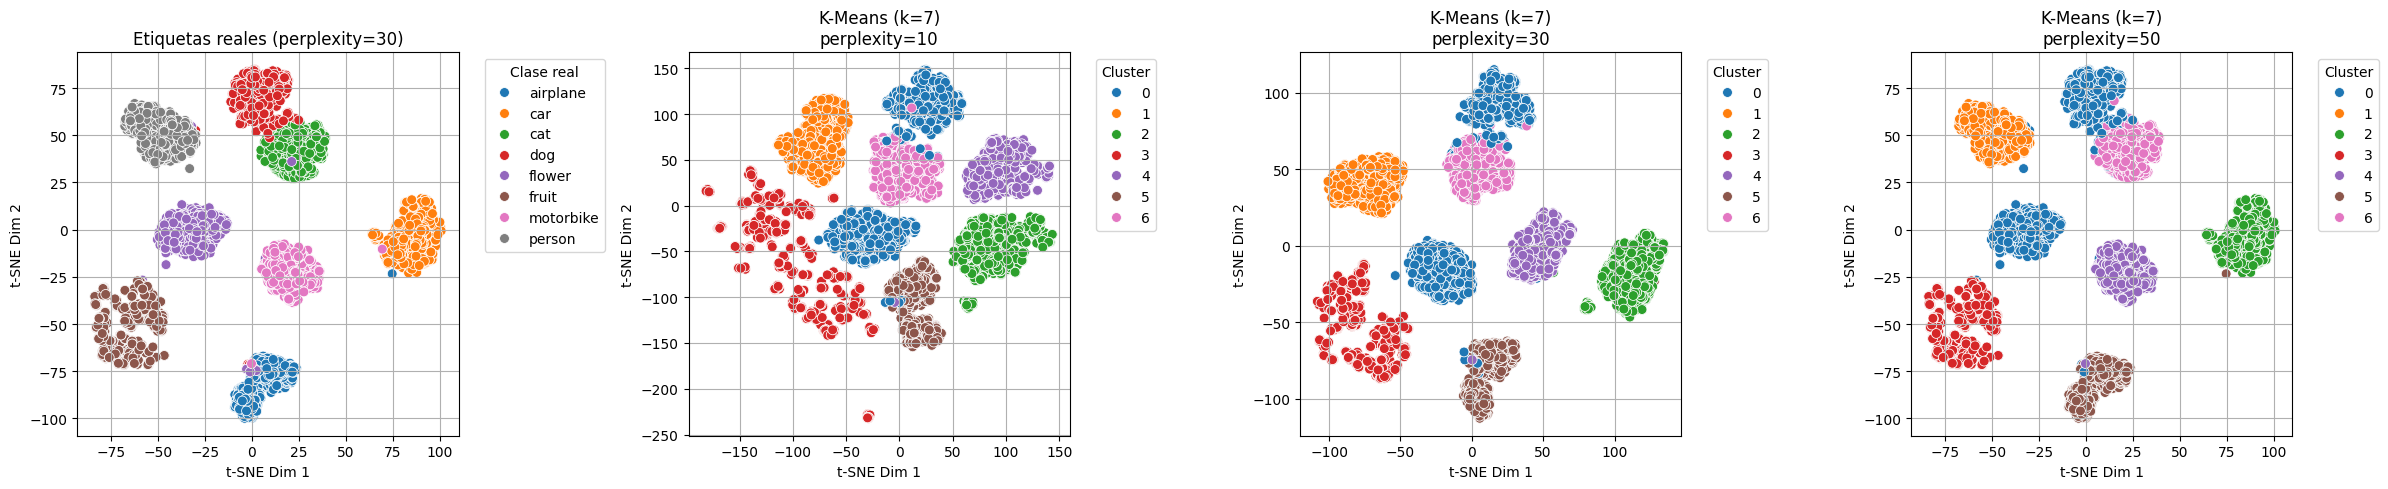

In [126]:
# === Cargar etiquetas reales ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
y_true = df['label'].tolist()

# === Codificar etiquetas como números para visualización opcional ===
unique_labels = sorted(set(y_true))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_true_num = [label_to_int[label] for label in y_true]
n_classes = len(unique_labels)

# === Ejecutar K-Means ===
k_optimo = 7
kmeans = KMeans(n_clusters=k_optimo, init='k-means++', random_state=42, n_init='auto')
labels_kmeans = kmeans.fit_predict(X_pca_reducido)  # Usa tu matriz PCA reducida

# === Crear gráfico de 4 paneles ===
plt.figure(figsize=(24, 5))

# === Gráfico 1: Etiquetas reales con t-SNE (una sola proyección con perplexity=50) ===
tsne_labels = TSNE(n_components=2, perplexity=50, max_iter=5000, random_state=42)
X_tsne_labels = tsne_labels.fit_transform(X_pca_reducido)

plt.subplot(1, 4, 1)
sns.scatterplot(x=X_tsne_labels[:, 0], y=X_tsne_labels[:, 1], hue=y_true, palette='tab10', s=50)
plt.title("Etiquetas reales (perplexity=30)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Clase real", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# === Gráficos 2 a 4: K-Means con distintas perplexities ===
perplexities = [10, 30, 50]
for i, perp in enumerate(perplexities):
    tsne_kmeans = TSNE(n_components=2, perplexity=perp, max_iter=5000, random_state=42)
    X_tsne_kmeans = tsne_kmeans.fit_transform(X_pca_reducido)
    
    plt.subplot(1, 4, i + 2)
    sns.scatterplot(x=X_tsne_kmeans[:, 0], y=X_tsne_kmeans[:, 1], hue=labels_kmeans, palette='tab10', s=50)
    plt.title(f"K-Means (k={k_optimo})\nperplexity={perp}")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

plt.tight_layout()
plt.show()

#### T-SNE 3D

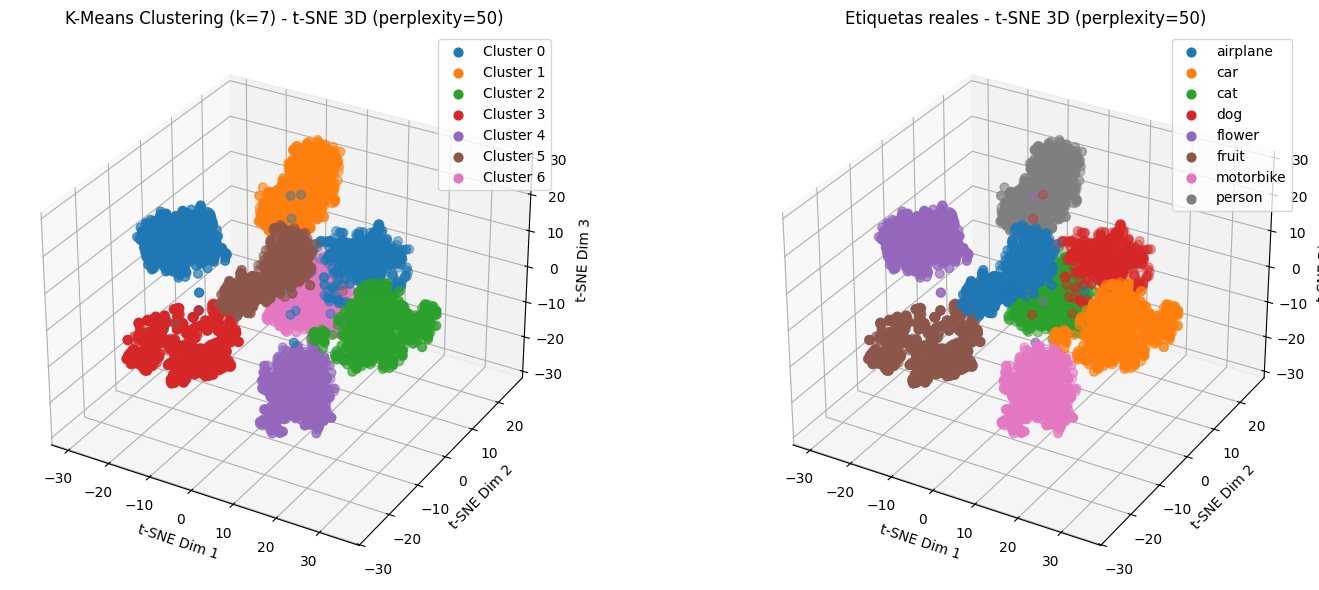

In [128]:
# === 1. Cargar etiquetas reales desde CSV ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
y_true = df['label'].tolist()

# === 2. Codificar etiquetas de texto como enteros para el gráfico ===
unique_labels = sorted(set(y_true))
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
y_true_num = [label_to_int[label] for label in y_true]
n_classes = len(unique_labels)

# === 3. Ejecutar K-Means con k óptimo ===
k_optimo = 7
kmeans = KMeans(n_clusters=k_optimo, init='k-means++', random_state=42, n_init='auto')
labels_kmeans = kmeans.fit_predict(X_pca_reducido)  # Usa tus datos PCA reducidos

# === 4. Ejecutar t-SNE con 3 componentes y perplexity 50 ===
tsne_3d = TSNE(n_components=3, perplexity=50, max_iter=5000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_pca_reducido)

# === 5. Visualización 3D lado a lado ===
fig = plt.figure(figsize=(16, 6))



# --- Gráfico 2: Etiquetas reales ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
colors_labels = sns.color_palette("tab10", n_classes)

for i, label in enumerate(unique_labels):
    class_points = X_tsne_3d[np.array(y_true) == label]
    ax2.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 2],
                label=label, color=colors_labels[i], s=40)

ax2.set_title("Etiquetas reales - t-SNE 3D (perplexity=50)")
ax2.set_xlabel("t-SNE Dim 1")
ax2.set_ylabel("t-SNE Dim 2")
ax2.set_zlabel("t-SNE Dim 3")
ax2.legend(loc='best')

# --- Gráfico 1: Clusters K-Means ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
colors_kmeans = sns.color_palette("tab10", k_optimo)

for i in range(k_optimo):
    cluster_points = X_tsne_3d[np.array(labels_kmeans) == i]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                label=f'Cluster {i}', color=colors_kmeans[i], s=40)

ax1.set_title(f"K-Means Clustering (k={k_optimo}) - t-SNE 3D (perplexity=50)")
ax1.set_xlabel("t-SNE Dim 1")
ax1.set_ylabel("t-SNE Dim 2")
ax1.set_zlabel("t-SNE Dim 3")
ax1.legend(loc='best')

plt.tight_layout()
plt.show()


### Resumen

Resumen metodológico: Selección del número óptimo de clusters mediante K-Means, SSE, Silhouette y validación por bootstrap

Con el fin de determinar el número óptimo de clusters en un modelo de agrupamiento K-Means, se desarrolló una metodología compuesta por cuatro fases, aplicadas sobre una versión de los datos reducida mediante Análisis de Componentes Principales (PCA). Esta estrategia combinó técnicas determinísticas y estocásticas para mejorar la robustez de los resultados.
1. Análisis del Coeficiente de Silhouette

Se aplicó K-Means para un rango de valores de kk entre 2 y 49. Para cada valor, se calculó el Silhouette Score, métrica que evalúa la separación entre los clusters y la cohesión interna de cada grupo.

Mediante la función argrelextrema de scipy.signal, se identificaron los máximos locales en la curva del Silhouette Score, los cuales representan configuraciones de clustering especialmente bien definidas. Estos puntos fueron considerados como candidatos óptimos para kk.
2. Análisis del Error Cuadrático Total (SSE)

Paralelamente, se evaluó el Sum of Squared Errors (SSE) —o inercia— para el mismo rango de kk. Esta métrica representa la compacidad interna de los clusters. Se identificaron los mínimos locales en la curva de SSE, los cuales sugieren puntos donde aumentar kk ya no mejora sustancialmente la estructura de los grupos, lo que se conoce como el “método del codo”.
3. Validación mediante Bootstrap con Silhouette Score

Dado que los resultados del agrupamiento pueden variar dependiendo de la muestra y del estado inicial del algoritmo, se aplicó un procedimiento de bootstrap con 500 repeticiones para validar la estabilidad del Silhouette Score. En cada iteración:

    Se generó una muestra con reemplazo del conjunto de datos PCA.

    Se ejecutó K-Means para valores de kk entre 2 y 15.

    Se calculó el Silhouette Score correspondiente.

Esto permitió estimar la distribución empírica del Silhouette Score para cada kk, y derivar a partir de ella medidas de tendencia central, dispersión e intervalos de confianza. Esta información facilita una comparación más precisa entre configuraciones, considerando la variabilidad natural del algoritmo.
4. Validación mediante Bootstrap con SSE

De forma análoga, se realizó un procedimiento de bootstrap sobre SSE. En cada una de las 500 iteraciones:

    Se aplicó K-Means a una muestra con reemplazo.

    Se calcularon los valores de SSE para kk de 2 a 15.

Esto permitió estimar la distribución del SSE por cada kk y obtener intervalos de confianza sobre la compacidad del agrupamiento. Además de permitir comparar la media del SSE, este enfoque evalúa la estabilidad de los resultados y su sensibilidad a variaciones en la muestra.
Conclusión metodológica

Esta metodología integradora permite una selección más robusta del número óptimo de clusters, al no depender únicamente de heurísticas visuales, sino también de evidencia estadística. El uso de técnicas de bootstrap permite capturar la variabilidad inherente del proceso de agrupamiento y establecer intervalos de confianza sobre las métricas clave, lo que aporta mayor rigor a la elección final de kk.



## Etiquetas reales vs Clusters - Matriz de confusión


📊 Tabla de Contingencia (Clases reales vs Clusters KMeans):

Cluster Asignado    0    1    2    3    4    5    6
Etiqueta Real                                      
airplane            2    0    0    0    0  725    0
car                 0    0  968    0    0    0    0
cat                26    0    0    0    0    1  858
dog               692    0    0    0    0    4    6
flower            839    0    0    0    0    3    1
fruit               4    0    0  995    0    1    0
motorbike           0    0    1    0  787    0    0
person              1  985    0    0    0    0    0


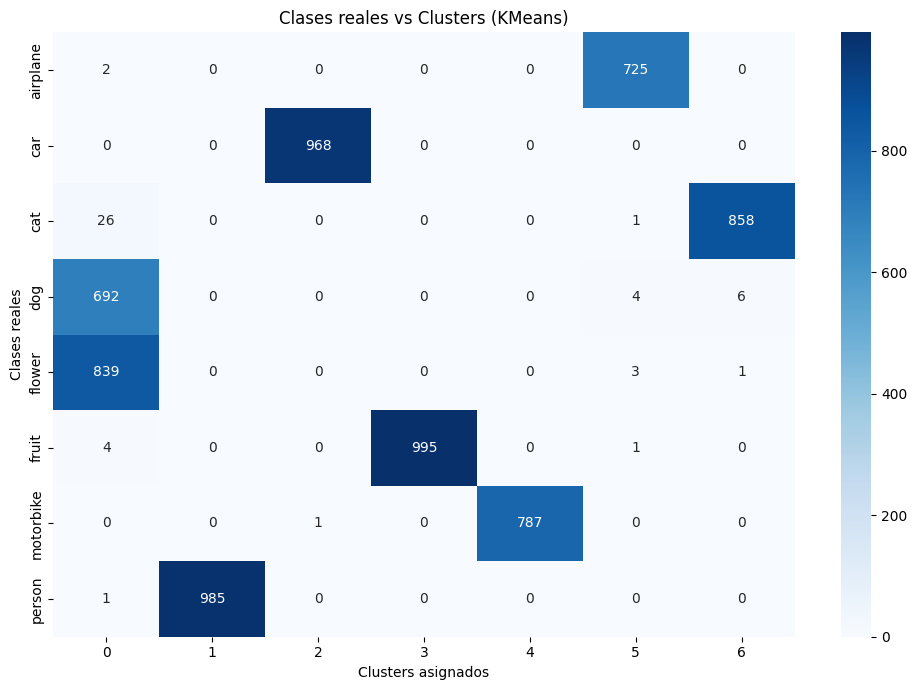


🔢 Índice de Rand Ajustado (ARI): 0.8800
📐 Índice de van Dongen: 0.0574


In [ ]:
# === 1. Cargar etiquetas reales ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
label = df['label'].tolist()  # Etiquetas reales (texto)

# === 2. Codificar etiquetas reales para métricas ===
le = LabelEncoder()
y_true_num = le.fit_transform(label)
class_names = le.classes_

# === 3. Ejecutar KMeans con k óptimo ===
k_optimo = 7
kmeans = KMeans(n_clusters=k_optimo, init='k-means++', random_state=42, n_init='auto')
labels_kmeans = kmeans.fit_predict(X_pca_reducido)

# === 4. Tabla de contingencia (crosstab entre clases reales y clusters) ===
ct = pd.crosstab(pd.Series(label, name="Etiqueta Real"), 
                 pd.Series(labels_kmeans, name="Cluster Asignado"))

print("\n📊 Tabla de Contingencia (Clases reales vs Clusters KMeans):\n")
print(ct)

# === 5. Visualizar como heatmap ===
plt.figure(figsize=(10, 7))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title("Clases reales vs Clusters (KMeans)")
plt.xlabel("Clusters asignados")
plt.ylabel("Clases reales")
plt.tight_layout()
plt.show()

# === 6. Métricas de evaluación ===
ari = adjusted_rand_score(y_true_num, labels_kmeans)
vd = van_dongen_score(y_true_num, labels_kmeans)

print(f"\n🔢 Índice de Rand Ajustado (ARI): {ari:.4f}")
print(f"📐 Índice de van Dongen: {vd:.4f}")



La matriz de confusión obtenida al comparar los clusters generados por el algoritmo K-Means (con k=7) con las etiquetas reales de las imágenes revela una correspondencia altamente precisa en la mayoría de las clases. Categorías como car, person, fruit y motorbike fueron correctamente agrupadas en un único cluster con una precisión prácticamente perfecta, superando el 99.5 %. Asimismo, airplane y cat también presentaron una asignación dominante en un solo cluster, aunque con ligeras dispersiones. No obstante, se detectó un solapamiento considerable en el cluster 0, el cual agrupa conjuntamente imágenes de dog y flower, indicando una confusión estructural entre estas dos clases en el espacio de representación. Esta mezcla sugiere que las características extraídas no lograron separar completamente dichas clases, lo que podría atribuirse a similitudes visuales o a limitaciones en la reducción de dimensionalidad previa al clustering. A pesar de esta excepción, la segmentación general alcanzada por K-Means refleja una fuerte alineación con la estructura subyacente de las categorías reales.
Para evaluar la calidad del agrupamiento con k=7k=7, se compararon los clusters obtenidos mediante K-Means con las clases reales de las imágenes. Se utilizó el índice de Rand Ajustado (ARI), que arrojó un valor de 0.8800, lo cual indica una coincidencia fuerte entre los agrupamientos y las categorías reales. Asimismo, se calculó el índice de van Dongen, obteniendo 0.0574, lo que sugiere una baja disimilitud estructural entre ambas particiones. Estos resultados respaldan que el modelo K-Means logró una segmentación efectiva y coherente con las clases originales.

# Clustering Jerarquico


🔗 Linkage: ward



🔗 Linkage: complete

🔗 Linkage: average

🔗 Linkage: single


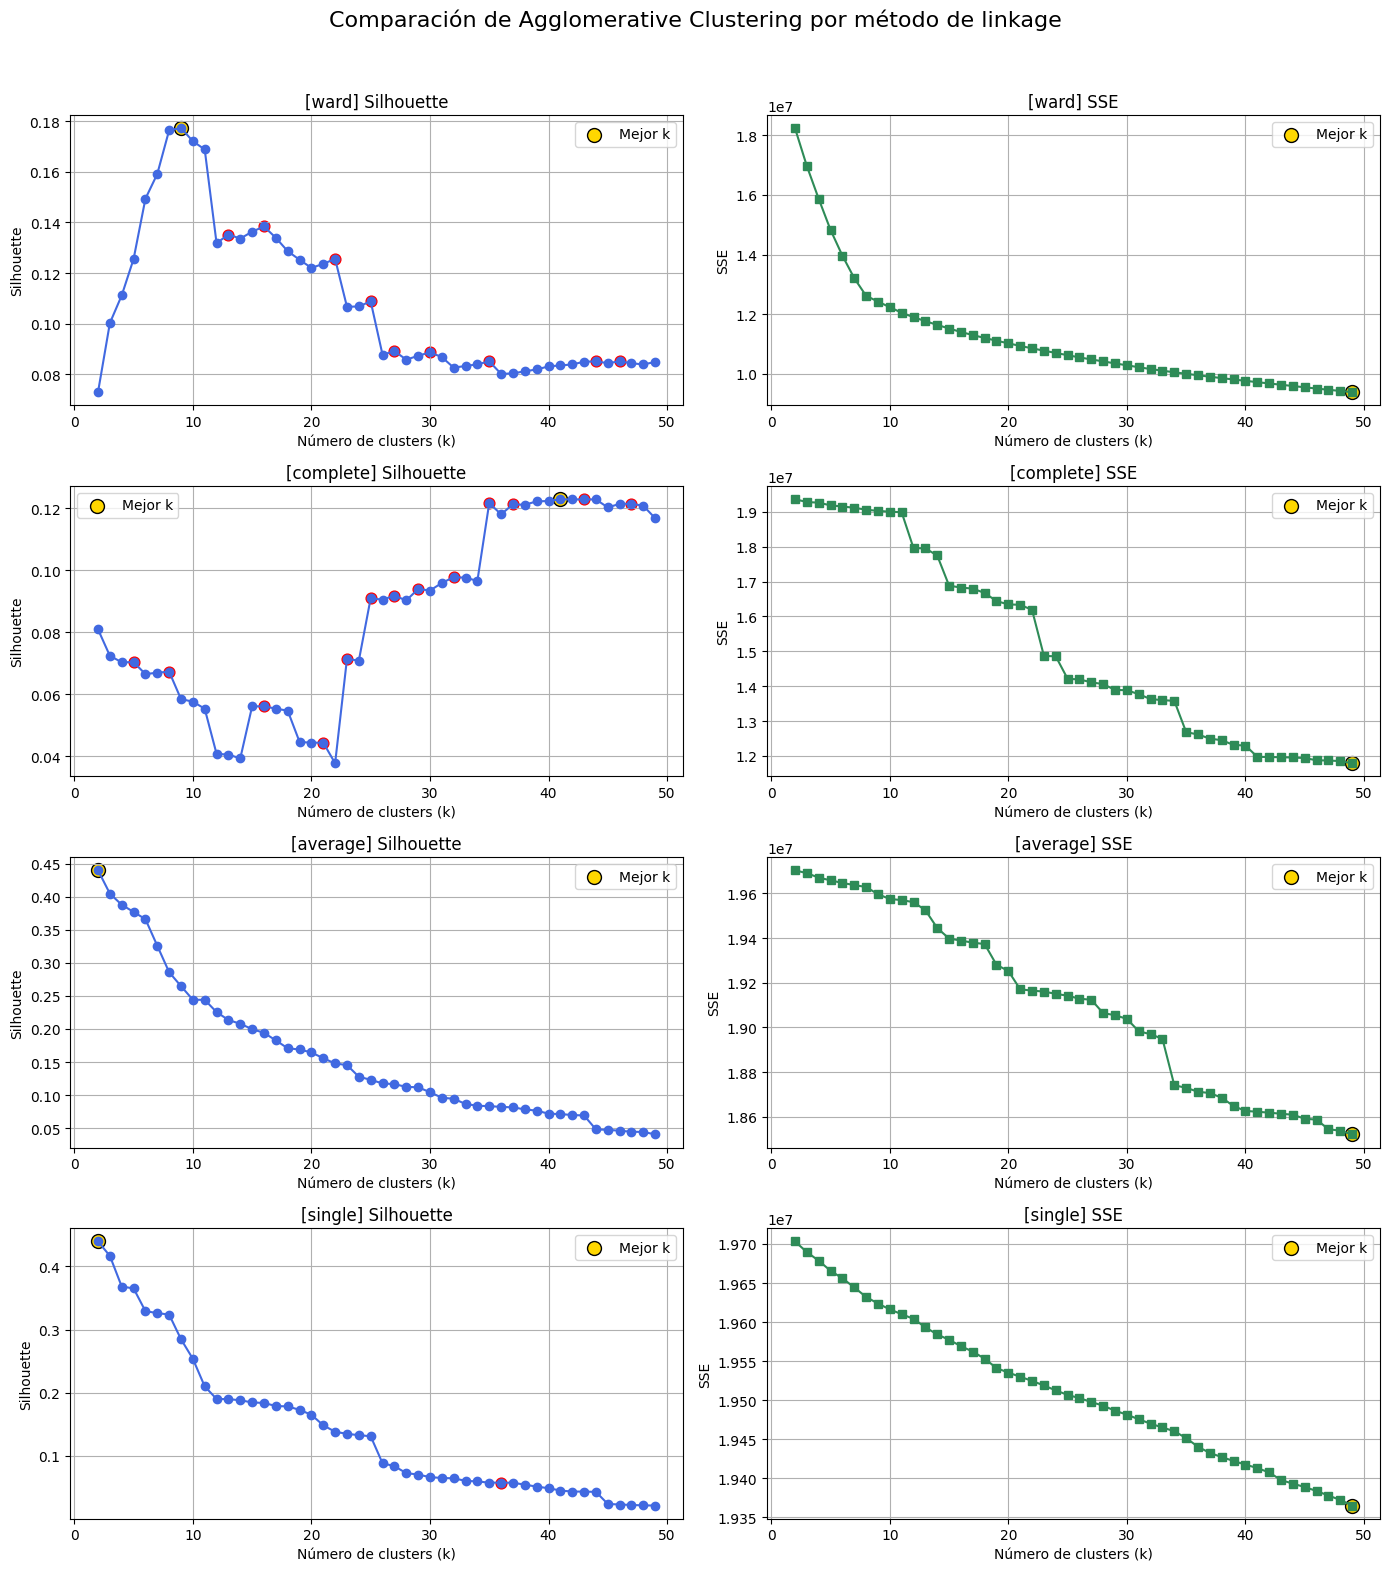


📊 Resumen de resultados por método:

🔗 WARD
  → Mejor k (Silhouette): k = 9 | Silhouette = 0.1772
  → Mejor k (SSE):        k = 49 | SSE = 9392010.00

🔗 COMPLETE
  → Mejor k (Silhouette): k = 41 | Silhouette = 0.1230
  → Mejor k (SSE):        k = 49 | SSE = 11787898.00

🔗 AVERAGE
  → Mejor k (Silhouette): k = 2 | Silhouette = 0.4398
  → Mejor k (SSE):        k = 49 | SSE = 18521044.00

🔗 SINGLE
  → Mejor k (Silhouette): k = 2 | Silhouette = 0.4398
  → Mejor k (SSE):        k = 49 | SSE = 19365010.00


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import argrelextrema
import pandas as pd

X_scaled = X_pca_reducido


# === 2. Configuración ===
linkage_methods = ['ward', 'complete', 'average', 'single']
k_range = range(2, 50)

results_by_method = {}

# === 3. Loop principal ===
for method in linkage_methods:
    print(f"\n🔗 Linkage: {method}")

    silhouette_scores = []
    sse_scores = []

    for k in k_range:
        try:
            model = AgglomerativeClustering(n_clusters=k, linkage=method)
            labels = model.fit_predict(X_scaled)

            # Silhouette Score (solo si hay al menos 2 clusters)
            if len(np.unique(labels)) < 2:
                silhouette_scores.append(np.nan)
            else:
                sil_score = silhouette_score(X_scaled, labels)
                silhouette_scores.append(sil_score)

            # SSE (intra-cluster sum of squares)
            sse = sum(
                np.sum((X_scaled[labels == i] - X_scaled[labels == i].mean(axis=0)) ** 2)
                for i in np.unique(labels)
            )
            sse_scores.append(sse)

        except Exception as e:
            silhouette_scores.append(np.nan)
            sse_scores.append(np.nan)

    # Almacenar resultados
    sil_array = np.array(silhouette_scores)
    sse_array = np.array(sse_scores)

    best_sil_idx = np.nanargmax(sil_array)
    best_sse_idx = np.nanargmin(sse_array)

    max_sil_idx = argrelextrema(sil_array, np.greater)[0]
    min_sse_idx = argrelextrema(-sse_array, np.greater)[0]

    results_by_method[method] = {
        'silhouette': sil_array,
        'sse': sse_array,
        'max_sil_idx': max_sil_idx,
        'min_sse_idx': min_sse_idx,
        'best_sil_idx': best_sil_idx,
        'best_sse_idx': best_sse_idx,
    }


fig, axes = plt.subplots(len(linkage_methods), 2, figsize=(14, 4 * len(linkage_methods)))

for i, method in enumerate(linkage_methods):
    sil = results_by_method[method]['silhouette']
    sse = results_by_method[method]['sse']
    best_sil_idx = results_by_method[method]['best_sil_idx']
    best_sse_idx = results_by_method[method]['best_sse_idx']
    max_sil_idx = results_by_method[method]['max_sil_idx']
    min_sse_idx = results_by_method[method]['min_sse_idx']

    # Silhouette
    ax1 = axes[i, 0]
    ax1.plot(k_range, sil, marker='o', color='royalblue')
    ax1.set_title(f"[{method}] Silhouette")
    ax1.set_xlabel("Número de clusters (k)")
    ax1.set_ylabel("Silhouette")
    ax1.grid(True)
    for idx in max_sil_idx:
        ax1.scatter(k_range[idx], sil[idx], color='red', s=60)
    ax1.scatter(k_range[best_sil_idx], sil[best_sil_idx], color='gold', s=100, edgecolor='black', label='Mejor k')
    ax1.legend()

    # SSE
    ax2 = axes[i, 1]
    ax2.plot(k_range, sse, marker='s', color='seagreen')
    ax2.set_title(f"[{method}] SSE")
    ax2.set_xlabel("Número de clusters (k)")
    ax2.set_ylabel("SSE")
    ax2.grid(True)
    for idx in min_sse_idx:
        ax2.scatter(k_range[idx], sse[idx], color='red', s=60)
    ax2.scatter(k_range[best_sse_idx], sse[best_sse_idx], color='gold', s=100, edgecolor='black', label='Mejor k')
    ax2.legend()

plt.suptitle("Comparación de Agglomerative Clustering por método de linkage", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n📊 Resumen de resultados por método:")
for method in linkage_methods:
    k_sil = k_range[results_by_method[method]['best_sil_idx']]
    sil_val = results_by_method[method]['silhouette'][results_by_method[method]['best_sil_idx']]
    k_sse = k_range[results_by_method[method]['best_sse_idx']]
    sse_val = results_by_method[method]['sse'][results_by_method[method]['best_sse_idx']]

    print(f"\n🔗 {method.upper()}")
    print(f"  → Mejor k (Silhouette): k = {k_sil} | Silhouette = {sil_val:.4f}")
    print(f"  → Mejor k (SSE):        k = {k_sse} | SSE = {sse_val:.2f}")



🔗 Linkage: ward



🔗 Linkage: complete

🔗 Linkage: average

🔗 Linkage: single


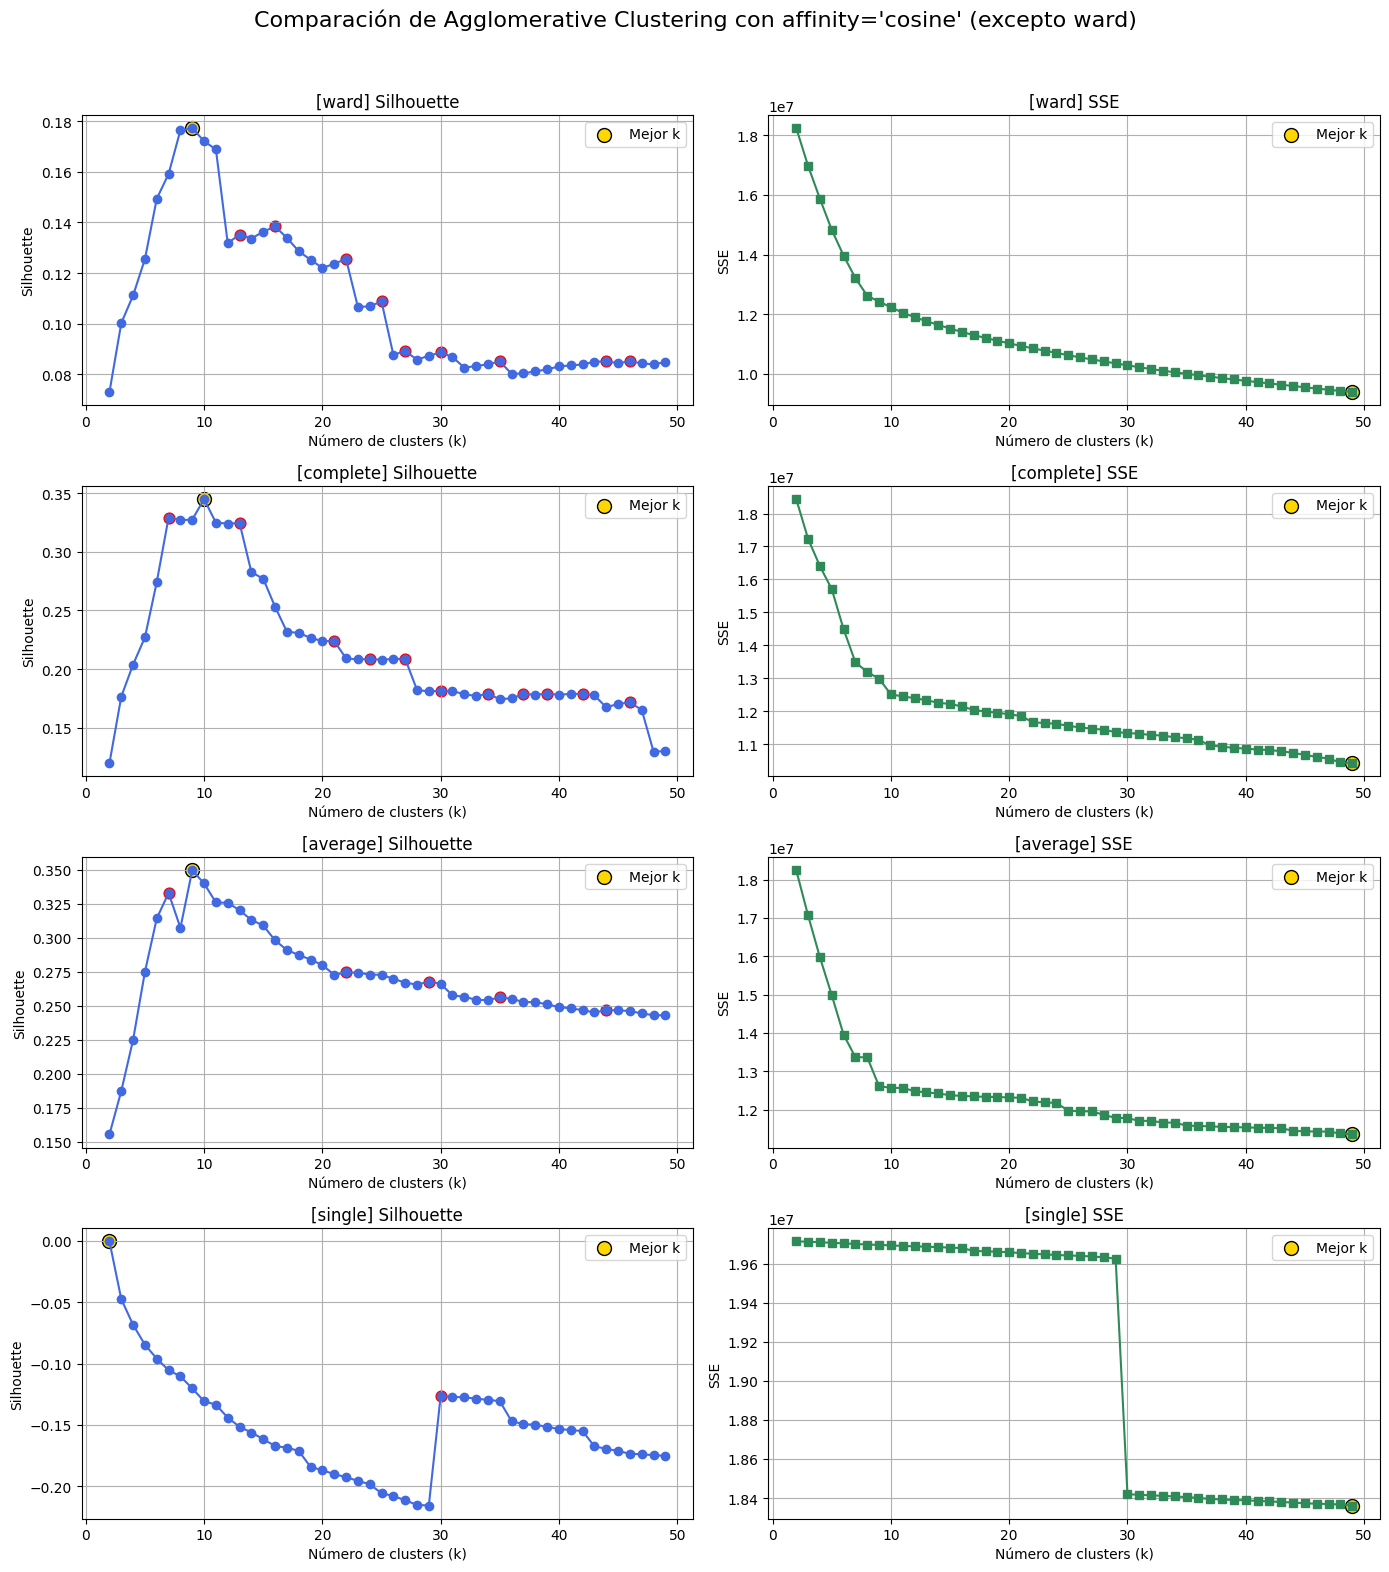


📊 Resumen de resultados por método:

🔗 WARD
  → Mejor k (Silhouette): k = 9 | Silhouette = 0.1772
  → Mejor k (SSE):        k = 49 | SSE = 9392010.00

🔗 COMPLETE
  → Mejor k (Silhouette): k = 10 | Silhouette = 0.3449
  → Mejor k (SSE):        k = 49 | SSE = 10418127.00

🔗 AVERAGE
  → Mejor k (Silhouette): k = 9 | Silhouette = 0.3494
  → Mejor k (SSE):        k = 49 | SSE = 11355465.00

🔗 SINGLE
  → Mejor k (Silhouette): k = 2 | Silhouette = -0.0006
  → Mejor k (SSE):        k = 49 | SSE = 18361562.00


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.signal import argrelextrema
import pandas as pd

X_scaled = X_pca_reducido  # Ya está normalizado y reducido → No reescalar

# Métodos de linkage
linkage_methods = ['ward', 'complete', 'average', 'single']
k_range = range(2, 50)
results_by_method = {}

for method in linkage_methods:
    print(f"\n🔗 Linkage: {method}")

    silhouette_scores = []
    sse_scores = []

    for k in k_range:
        try:
            # Configurar affinity según el método
            if method == 'ward':
                model = AgglomerativeClustering(n_clusters=k, linkage='ward')
                sil_metric = 'euclidean'
            else:
                model = AgglomerativeClustering(n_clusters=k, linkage=method, metric='cosine')
                sil_metric = 'cosine'

            labels = model.fit_predict(X_scaled)

            # Silhouette Score (si hay más de 1 cluster)
            if len(np.unique(labels)) < 2:
                silhouette_scores.append(np.nan)
            else:
                sil_score = silhouette_score(X_scaled, labels, metric=sil_metric)
                silhouette_scores.append(sil_score)

            # SSE (solo para comparación, no ideal con cosine)
            sse = sum(
                np.sum((X_scaled[labels == i] - X_scaled[labels == i].mean(axis=0)) ** 2)
                for i in np.unique(labels)
            )
            sse_scores.append(sse)

        except Exception as e:
            print(f"⚠️ Error con método {method}, k={k}: {e}")
            silhouette_scores.append(np.nan)
            sse_scores.append(np.nan)

    # Guardar resultados
    sil_array = np.array(silhouette_scores)
    sse_array = np.array(sse_scores)
    best_sil_idx = np.nanargmax(sil_array)
    best_sse_idx = np.nanargmin(sse_array)
    max_sil_idx = argrelextrema(sil_array, np.greater)[0]
    min_sse_idx = argrelextrema(-sse_array, np.greater)[0]

    results_by_method[method] = {
        'silhouette': sil_array,
        'sse': sse_array,
        'max_sil_idx': max_sil_idx,
        'min_sse_idx': min_sse_idx,
        'best_sil_idx': best_sil_idx,
        'best_sse_idx': best_sse_idx,
    }

# === Gráficos ===
fig, axes = plt.subplots(len(linkage_methods), 2, figsize=(14, 4 * len(linkage_methods)))

for i, method in enumerate(linkage_methods):
    sil = results_by_method[method]['silhouette']
    sse = results_by_method[method]['sse']
    best_sil_idx = results_by_method[method]['best_sil_idx']
    best_sse_idx = results_by_method[method]['best_sse_idx']
    max_sil_idx = results_by_method[method]['max_sil_idx']
    min_sse_idx = results_by_method[method]['min_sse_idx']

    # Silhouette
    ax1 = axes[i, 0]
    ax1.plot(k_range, sil, marker='o', color='royalblue')
    ax1.set_title(f"[{method}] Silhouette")
    ax1.set_xlabel("Número de clusters (k)")
    ax1.set_ylabel("Silhouette")
    ax1.grid(True)
    for idx in max_sil_idx:
        ax1.scatter(k_range[idx], sil[idx], color='red', s=60)
    ax1.scatter(k_range[best_sil_idx], sil[best_sil_idx], color='gold', s=100, edgecolor='black', label='Mejor k')
    ax1.legend()

    # SSE
    ax2 = axes[i, 1]
    ax2.plot(k_range, sse, marker='s', color='seagreen')
    ax2.set_title(f"[{method}] SSE")
    ax2.set_xlabel("Número de clusters (k)")
    ax2.set_ylabel("SSE")
    ax2.grid(True)
    for idx in min_sse_idx:
        ax2.scatter(k_range[idx], sse[idx], color='red', s=60)
    ax2.scatter(k_range[best_sse_idx], sse[best_sse_idx], color='gold', s=100, edgecolor='black', label='Mejor k')
    ax2.legend()

plt.suptitle("Comparación de Agglomerative Clustering con affinity='cosine' (excepto ward)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# === Resumen ===
print("\n📊 Resumen de resultados por método:")
for method in linkage_methods:
    k_sil = k_range[results_by_method[method]['best_sil_idx']]
    sil_val = results_by_method[method]['silhouette'][results_by_method[method]['best_sil_idx']]
    k_sse = k_range[results_by_method[method]['best_sse_idx']]
    sse_val = results_by_method[method]['sse'][results_by_method[method]['best_sse_idx']]

    print(f"\n🔗 {method.upper()}")
    print(f"  → Mejor k (Silhouette): k = {k_sil} | Silhouette = {sil_val:.4f}")
    print(f"  → Mejor k (SSE):        k = {k_sse} | SSE = {sse_val:.2f}")


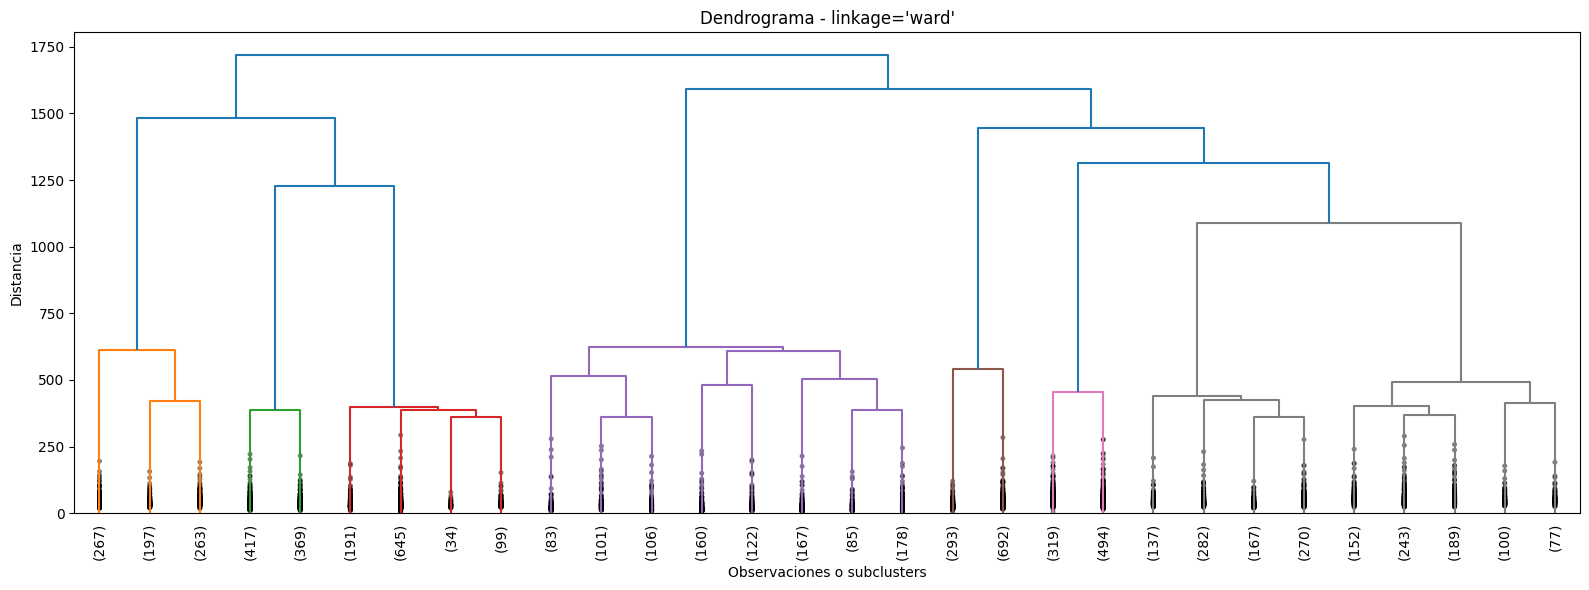

In [23]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# === Método de linkage que quieras visualizar (de los usados en AgglomerativeClustering)
linkage_method = 'ward'  # puedes cambiar por 'complete', 'average', 'single', etc.

# === Usa los mismos datos escalados que usaste con AgglomerativeClustering
linked = linkage(X_scaled, method=linkage_method)

# === Dibuja el dendrograma
plt.figure(figsize=(16, 6))
dendrogram(
    linked,
    truncate_mode='lastp',  # Mostrar solo las últimas ramas (p últimos clusters)
    p=30,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    color_threshold=None
)
plt.title(f"Dendrograma - linkage='{linkage_method}'")
plt.xlabel("Observaciones o subclusters")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()


In [25]:
from scipy.spatial.distance import pdist, squareform

# Usamos X_pca_reducido directamente (ya normalizado y reducido)
distance_matrix = pdist(X_pca_reducido, metric='euclidean')  # o 'cosine', 'correlation', etc.

# Convertir a matriz cuadrada
dist_square = squareform(distance_matrix)

# Visualizar una parte de la matriz
print("📏 Matriz de distancias:")
print(dist_square[:5, :5])



📏 Matriz de distancias:
[[ 0.         62.21772859 54.75904981 47.35357064 38.76417343]
 [62.21772859  0.         54.97283188 72.13564431 65.87086261]
 [54.75904981 54.97283188  0.         59.45343959 54.64753683]
 [47.35357064 72.13564431 59.45343959  0.         45.88360786]
 [38.76417343 65.87086261 54.64753683 45.88360786  0.        ]]



📊 Tabla de Contingencia (Clases reales vs Clusters Agglomerative):

Cluster Asignado    0    1    2    3    4    5    6    7    8
Etiqueta Real                                                
airplane          727    0    0    0    0    0    0    0    0
car                 0    0    0    0    0    0    0  968    0
cat                 0    0   35    0    0    0    0    0  850
dog                 0    0  697    0    0    0    0    0    5
flower              0    0   27    2    0  813    0    0    1
fruit               0  712    0  288    0    0    0    0    0
motorbike           0    0    1    0    0    0  786    1    0
person              0    0    1    0  985    0    0    0    0


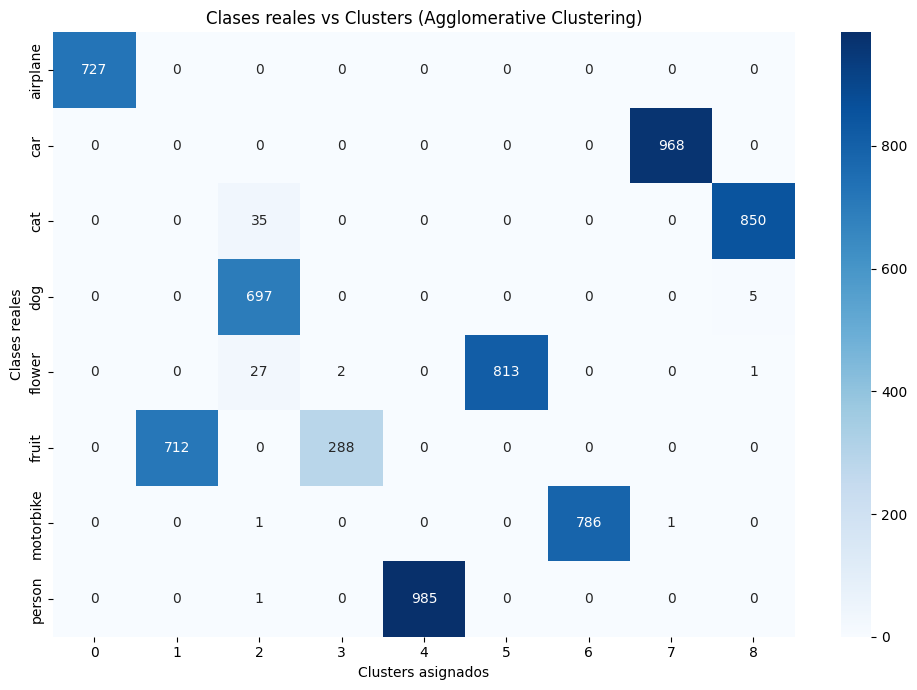


🔢 Índice de Rand Ajustado (ARI): 0.9379
📐 V-Measure Score: 0.9564


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import v_measure_score

# === 1. Cargar etiquetas reales ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
label = df['label'].tolist()

# === 2. Codificar etiquetas reales ===
le = LabelEncoder()
y_true_num = le.fit_transform(label)
class_names = le.classes_

# === 3. Clustering Jerárquico con k=9 y linkage='ward' ===
k_optimo = 9
model = AgglomerativeClustering(n_clusters=k_optimo, linkage='ward')
labels_agglo = model.fit_predict(X_pca_reducido)  # Usar directamente PCA reducido

# === 4. Tabla de contingencia ===
ct = pd.crosstab(pd.Series(label, name="Etiqueta Real"), 
                 pd.Series(labels_agglo, name="Cluster Asignado"))

print("\n📊 Tabla de Contingencia (Clases reales vs Clusters Agglomerative):\n")
print(ct)

# === 5. Heatmap ===
plt.figure(figsize=(10, 7))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title("Clases reales vs Clusters (Agglomerative Clustering)")
plt.xlabel("Clusters asignados")
plt.ylabel("Clases reales")
plt.tight_layout()
plt.show()

# === 6. Métricas de evaluación ===
ari = adjusted_rand_score(y_true_num, labels_agglo)
v_measure = v_measure_score(y_true_num, labels_agglo)

print(f"\n🔢 Índice de Rand Ajustado (ARI): {ari:.4f}")
print(f"📐 V-Measure Score: {v_measure:.4f}")


Resumen de evaluación con etiquetas reales

Se aplicó clustering jerárquico aglomerativo (linkage='ward', k=9) y se compararon los clusters asignados con las etiquetas reales mediante una tabla de contingencia.

El modelo logró una segmentación precisa en la mayoría de las clases. Se obtuvieron:

    Adjusted Rand Index (ARI): 0.9379

    V-Measure Score: 0.9564

Ambas métricas indican un alto grado de coincidencia entre los clusters y las clases reales.

No obstante, se observa que la clase fruit se dividió en dos clusters principales:

    712 muestras en el cluster 1

    288 muestras en el cluster 3

Esto sugiere que fruit presenta variabilidad interna relevante que fue captada por el modelo, posiblemente reflejando subgrupos estructurados dentro de esa categoría.

/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ramarilla/economatica/MCD-CyT/dm_cyt/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


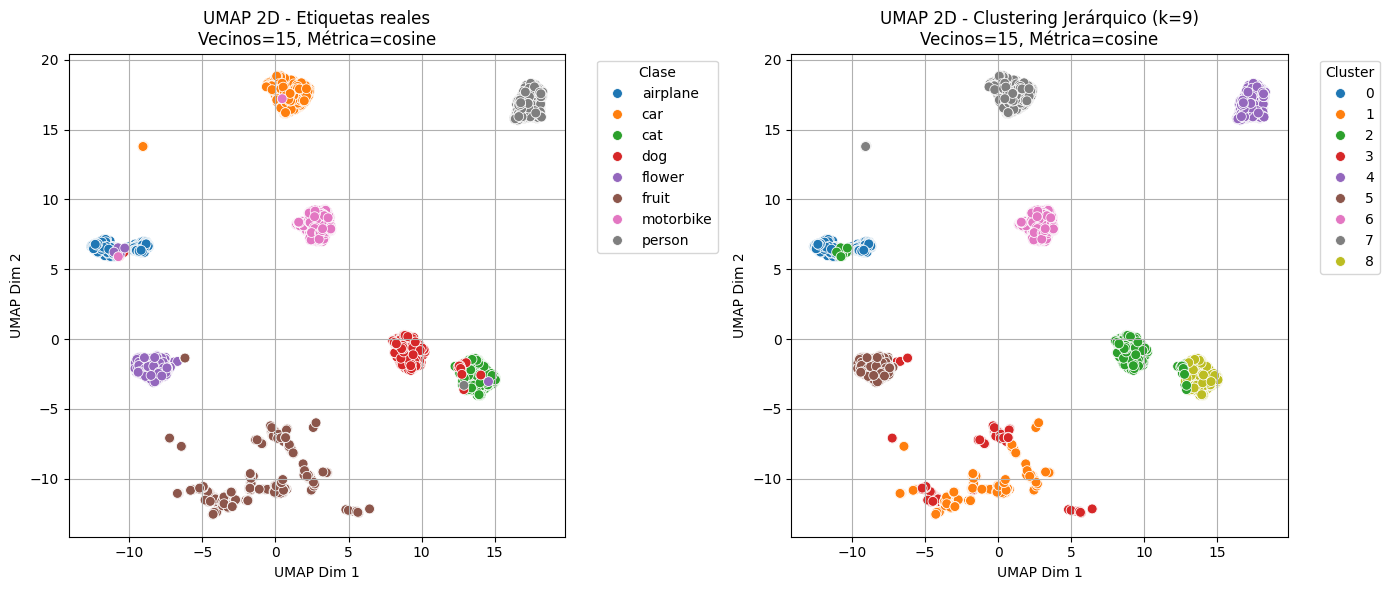

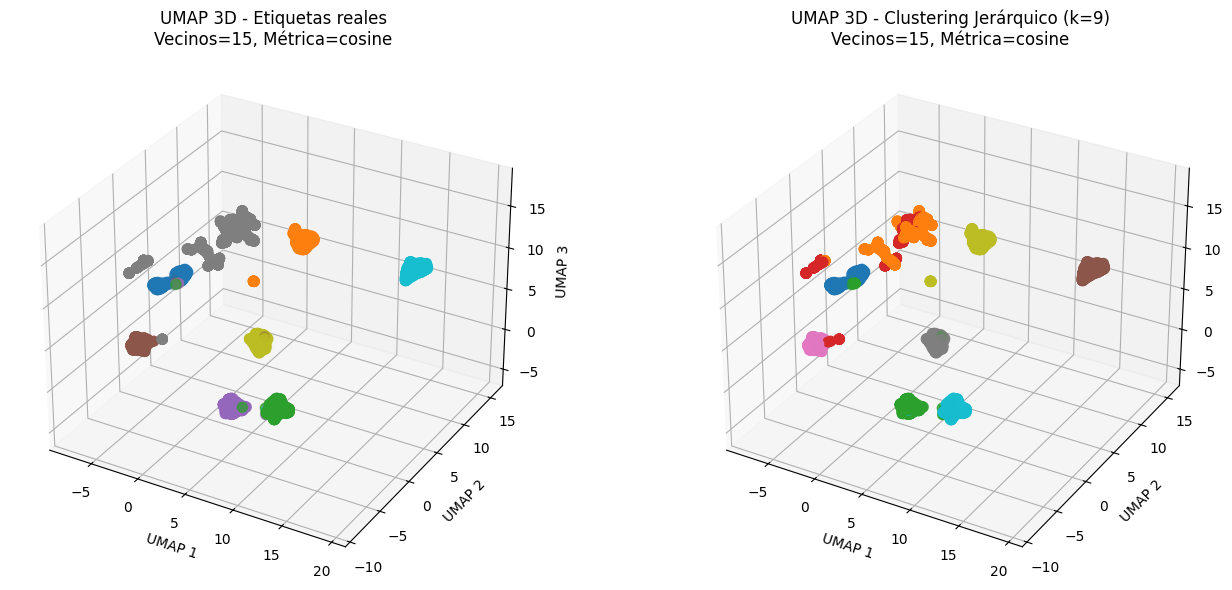

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

# === 1. Cargar etiquetas reales ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
y_true = df['label'].tolist()

# === 2. Codificar etiquetas ===
le = LabelEncoder()
y_true_num = le.fit_transform(y_true)
class_names = le.classes_

# === 3. Clustering jerárquico (linkage='ward', k=9) ===
k_optimo = 9
model = AgglomerativeClustering(n_clusters=k_optimo, linkage='ward')
labels_agglo = model.fit_predict(X_pca_reducido)

# === 4. UMAP - Configuración ===
n_neighbors = 15
umap_metric = 'cosine'

# === 5. UMAP - Reducción a 2D ===
umap_2d = umap.UMAP(n_components=2, n_neighbors=n_neighbors, metric=umap_metric, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_pca_reducido)

# === 6. UMAP - Reducción a 3D ===
umap_3d = umap.UMAP(n_components=3, n_neighbors=n_neighbors, metric=umap_metric, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_pca_reducido)

# === 7. Visualización 2D ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_umap_2d[:, 0], y=X_umap_2d[:, 1], hue=y_true, palette='tab10', s=50)
plt.title(f"UMAP 2D - Etiquetas reales\nVecinos={n_neighbors}, Métrica={umap_metric}")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap_2d[:, 0], y=X_umap_2d[:, 1], hue=labels_agglo, palette='tab10', s=50)
plt.title(f"UMAP 2D - Clustering Jerárquico (k={k_optimo})\nVecinos={n_neighbors}, Métrica={umap_metric}")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# === 8. Visualización 3D ===
fig = plt.figure(figsize=(14, 6))

# 3D - Etiquetas reales
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
                       c=y_true_num, cmap='tab10', s=50)
ax1.set_title(f"UMAP 3D - Etiquetas reales\nVecinos={n_neighbors}, Métrica={umap_metric}")
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")
ax1.set_zlabel("UMAP 3")

# 3D - Clusters jerárquicos
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
                       c=labels_agglo, cmap='tab10', s=50)
ax2.set_title(f"UMAP 3D - Clustering Jerárquico (k={k_optimo})\nVecinos={n_neighbors}, Métrica={umap_metric}")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
ax2.set_zlabel("UMAP 3")

plt.tight_layout()
plt.show()


Se aplicó clustering jerárquico aglomerativo sobre una matriz de datos previamente normalizada y reducida mediante PCA. Se evaluaron distintos métodos de enlace: ward, complete, average y single, variando la cantidad de clusters en un rango de k=2 a k=49.

Para cada configuración, se calcularon las métricas de Silhouette Score y SSE (Suma de Errores Cuadráticos). Los resultados fueron graficados para comparar visualmente el comportamiento de los diferentes métodos.

Adicionalmente, se realizó un análisis comparativo utilizando distancias euclidianas y de coseno en los métodos de enlace que lo permiten (complete, average, single). Se observó que el uso de la distancia coseno mejoró los valores de Silhouette en comparación con la distancia euclidiana. El método ward se mantuvo evaluado únicamente con distancia euclidiana por su restricción teórica.

Posteriormente, se aplicó Agglomerative Clustering con linkage='ward' y k=9k=9, utilizando las etiquetas reales del conjunto de datos para construir una tabla de contingencia, un heatmap, y calcular métricas de evaluación externas (ARI y V-Measure).

Finalmente, se utilizó UMAP con metric='cosine' para reducir los datos a 2 y 3 dimensiones, permitiendo visualizar las asignaciones de cluster y las clases reales en un espacio latente.

# Clustering por Densidad - DBSCAM

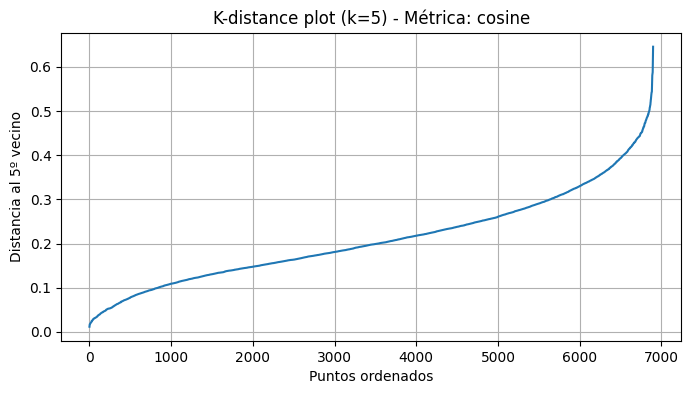

In [31]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 5  # suele usarse el mismo valor que min_samples
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X_pca_reducido)
distances, _ = nbrs.kneighbors(X_pca_reducido)
distances = np.sort(distances[:, -1])  # Tomar la distancia al k-ésimo vecino

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title(f"K-distance plot (k={k}) - Métrica: cosine")
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}º vecino")
plt.grid(True)
plt.show()


In [32]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = [3, 5, 7, 10]
metric = 'cosine'

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        labels = db.fit_predict(X_pca_reducido)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters >= 2:
            sil = silhouette_score(X_pca_reducido, labels, metric=metric)
            print(f"eps={eps:.2f}, min_samples={min_samples} → clusters={n_clusters}, silhouette={sil:.4f}")
        else:
            print(f"eps={eps:.2f}, min_samples={min_samples} → clusters={n_clusters}, silhouette=NA")


eps=0.10, min_samples=3 → clusters=150, silhouette=-0.3550
eps=0.10, min_samples=5 → clusters=64, silhouette=-0.3293
eps=0.10, min_samples=7 → clusters=43, silhouette=-0.2461
eps=0.10, min_samples=10 → clusters=22, silhouette=-0.2040
eps=0.20, min_samples=3 → clusters=67, silhouette=-0.0582
eps=0.20, min_samples=5 → clusters=36, silhouette=0.0706
eps=0.20, min_samples=7 → clusters=30, silhouette=0.0877
eps=0.20, min_samples=10 → clusters=23, silhouette=0.0425
eps=0.30, min_samples=3 → clusters=22, silhouette=0.1075
eps=0.30, min_samples=5 → clusters=17, silhouette=0.1842
eps=0.30, min_samples=7 → clusters=10, silhouette=0.2306
eps=0.30, min_samples=10 → clusters=10, silhouette=0.2537
eps=0.40, min_samples=3 → clusters=6, silhouette=0.2222
eps=0.40, min_samples=5 → clusters=7, silhouette=0.2120
eps=0.40, min_samples=7 → clusters=6, silhouette=0.2296
eps=0.40, min_samples=10 → clusters=6, silhouette=0.2999
eps=0.50, min_samples=3 → clusters=1, silhouette=NA
eps=0.50, min_samples=5 → clus

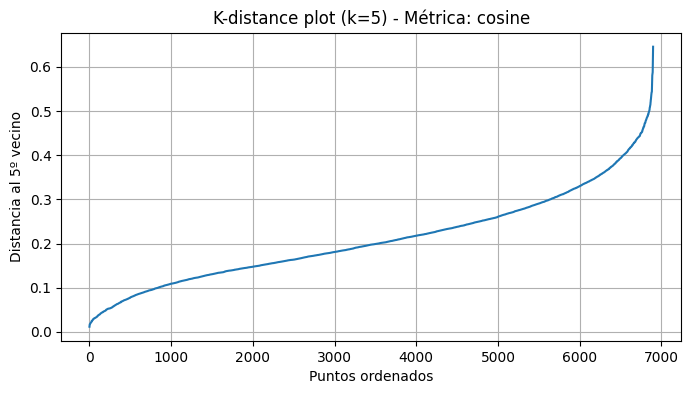


🔝 Mejores configuraciones DBSCAN por Silhouette:
    eps  min_samples  clusters  outliers  silhouette
23  0.4           16         6       280    0.300697
22  0.4           13         6       236    0.300233
21  0.4           10         6       205    0.299936
16  0.3           13        10      1099    0.255398
15  0.3           10        10       984    0.253732


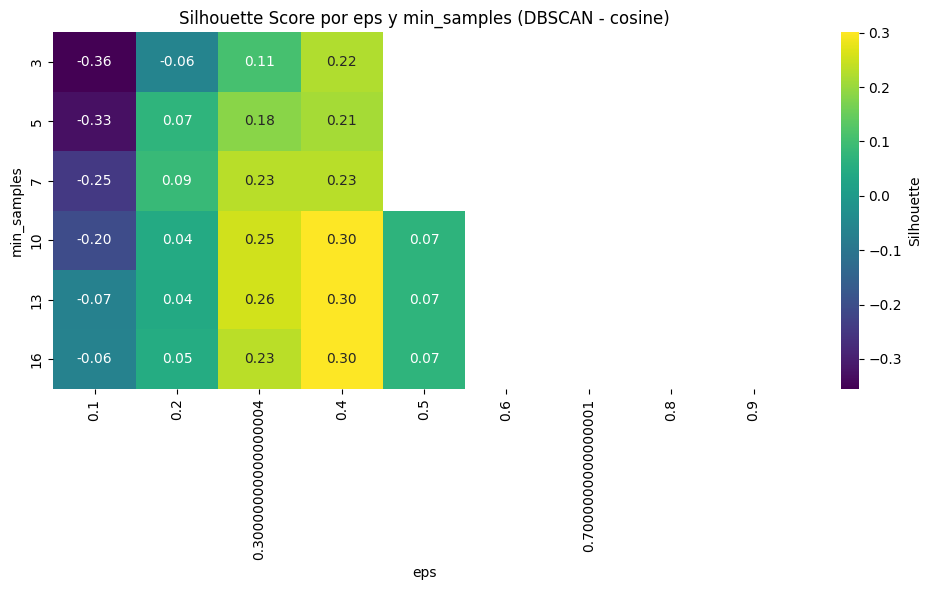

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# === Datos de entrada ===
X = X_pca_reducido  # Debe estar definido previamente (normalizado y con PCA)

# === 1. Estimar eps con K-distance plot ===
k = 5  # mismo que min_samples inicial
metric = 'cosine'

nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(X)
distances, _ = nbrs.kneighbors(X)
k_distances = np.sort(distances[:, -1])  # distancia al k-ésimo vecino

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f"K-distance plot (k={k}) - Métrica: {metric}")
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}º vecino")
plt.grid(True)
plt.show()

# === 2. Grid search sobre eps y min_samples ===
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = [3, 5, 7, 10,13,16]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        labels = db.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters >= 2:
            sil = silhouette_score(X, labels, metric=metric)
        else:
            sil = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'clusters': n_clusters,
            'outliers': n_noise,
            'silhouette': sil
        })

df_results = pd.DataFrame(results)

# === 3. Mostrar top 5 resultados ===
print("\n🔝 Mejores configuraciones DBSCAN por Silhouette:")
print(df_results.sort_values(by='silhouette', ascending=False).head())

# === 4. Heatmap Silhouette ===
pivot = df_results.pivot(index='min_samples', columns='eps', values='silhouette')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Silhouette'})
plt.title("Silhouette Score por eps y min_samples (DBSCAN - cosine)")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.tight_layout()
plt.show()


📌 Paso 1: Visualizando K-distance...


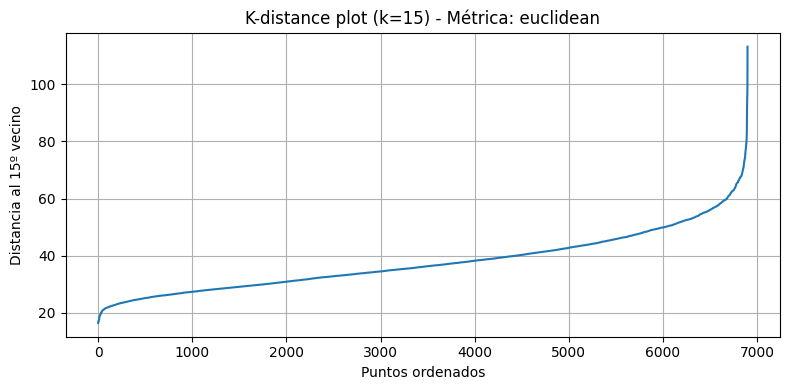

🔍 Paso 2: Realizando búsqueda de parámetros con DBSCAN...

🔝 Mejores configuraciones DBSCAN (ordenadas por Silhouette):
    eps  min_samples  clusters  outliers  silhouette
48  8.0            3         2      6891   -0.080516
40  7.0            3         2      6892   -0.084105
44  7.5            3         2      6892   -0.084105
56  9.0            3         8      6871   -0.085441
52  8.5            3         7      6876   -0.088598
🗺️ Paso 3: Visualizando resultados con heatmap...


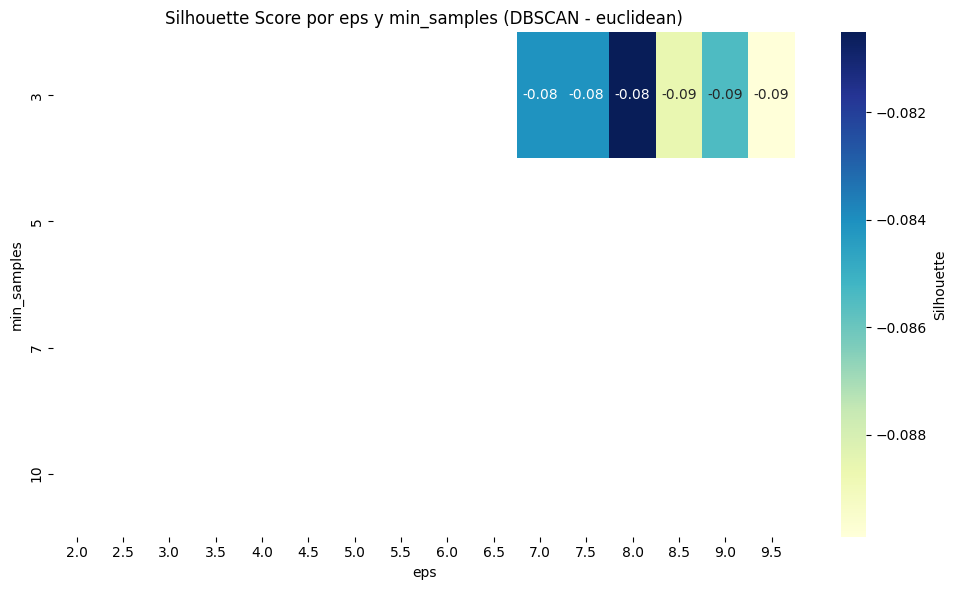

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# === 1. Función para plot de k-distancia ===
def plot_k_distance(X, k=5, metric='euclidean'):
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(X)
    distances, _ = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, -1])  # Último vecino

    plt.figure(figsize=(8, 4))
    plt.plot(k_distances)
    plt.title(f"K-distance plot (k={k}) - Métrica: {metric}")
    plt.xlabel("Puntos ordenados")
    plt.ylabel(f"Distancia al {k}º vecino")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 2. Función para Grid Search de DBSCAN ===
def dbscan_grid_search(X, eps_values, min_samples_values, metric='euclidean'):
    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            labels = db.fit_predict(X)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)

            if n_clusters >= 2:
                sil = silhouette_score(X, labels, metric=metric)
            else:
                sil = np.nan

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'clusters': n_clusters,
                'outliers': n_noise,
                'silhouette': sil
            })

    return pd.DataFrame(results)

# === 3. Función para heatmap ===
def plot_silhouette_heatmap(df_results, metric='euclidean'):
    pivot = df_results.pivot(index='min_samples', columns='eps', values='silhouette')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Silhouette'})
    plt.title(f"Silhouette Score por eps y min_samples (DBSCAN - {metric})")
    plt.xlabel("eps")
    plt.ylabel("min_samples")
    plt.tight_layout()
    plt.show()

# === 4. Parámetros e inicio ===
# Asegurate que X_pca_reducido esté definido y preprocesado antes de correr esto
X = X_pca_reducido  # Normalizado y/o reducido con PCA
metric = 'euclidean'
k = 15

# === 5. Paso a paso ===
print("📌 Paso 1: Visualizando K-distance...")
plot_k_distance(X, k=k, metric=metric)

print("🔍 Paso 2: Realizando búsqueda de parámetros con DBSCAN...")

eps_values = np.arange(2.0, 10.0, 0.5)

min_samples_values = [3, 5, 7, 10]

df_results = dbscan_grid_search(X, eps_values, min_samples_values, metric=metric)

print("\n🔝 Mejores configuraciones DBSCAN (ordenadas por Silhouette):")
print(df_results.sort_values(by='silhouette', ascending=False).head())

print("🗺️ Paso 3: Visualizando resultados con heatmap...")
plot_silhouette_heatmap(df_results, metric=metric)



Se aplicó el algoritmo DBSCAN para segmentar las imágenes en base a sus vectores de características reducidos. El análisis comparó el desempeño del algoritmo utilizando dos métricas de distancia: euclidiana y coseno.

Con la métrica euclidiana, DBSCAN no logró identificar agrupamientos significativos. En todas las configuraciones probadas, casi la totalidad de los puntos fueron etiquetados como outliers y los valores del Silhouette Score fueron negativos, lo que indica una pobre calidad de clustering.

En cambio, al usar la distancia coseno, los resultados mejoraron notablemente. Se formaron varios clusters con una baja proporción de outliers y valores de Silhouette Score en torno a 0.30, lo que refleja una estructura de grupos más definida. Esto sugiere que la distancia coseno es más adecuada para capturar la similitud entre imágenes en este espacio de representación.

En resumen, DBSCAN combinado con la métrica coseno permitió detectar agrupamientos útiles, mientras que con la métrica euclidiana no se logró segmentar de manera efectiva.


📊 Tabla de Contingencia (Clases reales vs Clusters DBSCAN):

Cluster Asignado    0    1    2    3    4    5
Etiqueta Real                                 
airplane          712    0    0    0    0    0
car                 1  966    0    0    0    0
cat                 1    0  827    0    0    0
dog                 3    0  590    0    0    0
flower              1    0    1  767    1    0
fruit               0    0    0    0  983    0
motorbike           1  784    0    0    0    0
person              0    0    0    0    0  981


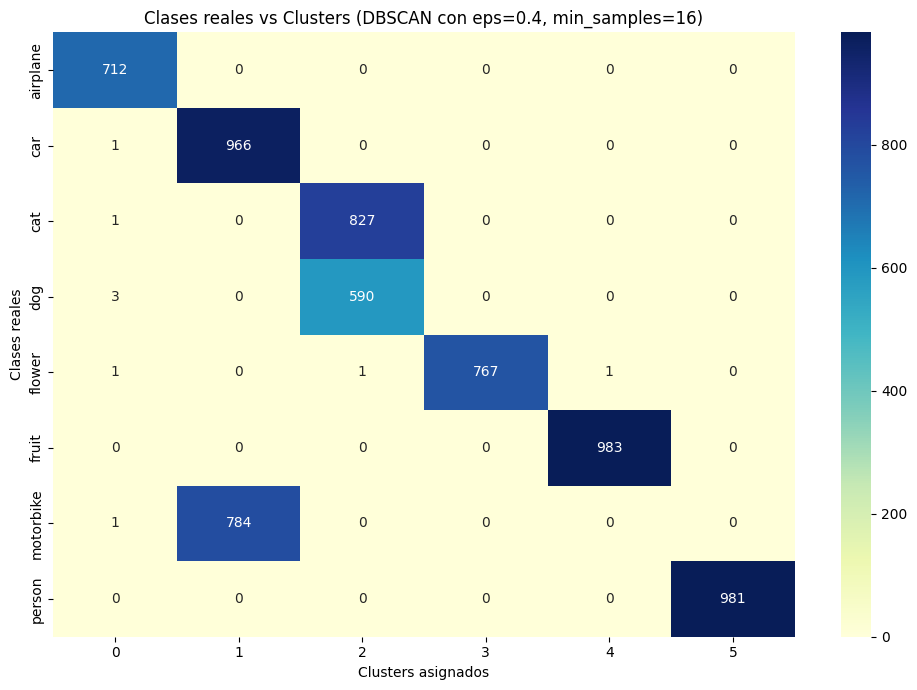


🔢 Índice de Rand Ajustado (ARI, sin outliers): 0.7836
📐 V-Measure Score (sin outliers): 0.9088
🧾 Total de puntos evaluados (sin outliers): 6619 / 6899


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, v_measure_score

# === 1. Cargar etiquetas reales ===
df = pd.read_csv(DIR + '/natural_images_labels.csv')
label = df['label'].tolist()

# === 2. Codificar etiquetas reales ===
le = LabelEncoder()
y_true_num = le.fit_transform(label)
class_names = le.classes_

# === 3. DBSCAN con mejor configuración encontrada ===
dbscan = DBSCAN(eps=0.4, min_samples=16, metric='cosine')
labels_dbscan = dbscan.fit_predict(X_pca_reducido)

# === 4. Filtrar outliers (-1) ===
mask = labels_dbscan != -1
labels_filtrados = labels_dbscan[mask]
y_true_filtrados = [y for i, y in enumerate(y_true_num) if mask[i]]

# === 5. Tabla de contingencia ===
ct = pd.crosstab(
    pd.Series([class_names[i] for i in y_true_filtrados], name="Etiqueta Real"),
    pd.Series(labels_filtrados, name="Cluster Asignado")
)

print("\n📊 Tabla de Contingencia (Clases reales vs Clusters DBSCAN):\n")
print(ct)

# === 6. Heatmap ===
plt.figure(figsize=(10, 7))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Clases reales vs Clusters (DBSCAN con eps=0.4, min_samples=16)")
plt.xlabel("Clusters asignados")
plt.ylabel("Clases reales")
plt.tight_layout()
plt.show()

# === 7. Métricas de evaluación ===
ari = adjusted_rand_score(y_true_filtrados, labels_filtrados)
v_measure = v_measure_score(y_true_filtrados, labels_filtrados)

print(f"\n🔢 Índice de Rand Ajustado (ARI, sin outliers): {ari:.4f}")
print(f"📐 V-Measure Score (sin outliers): {v_measure:.4f}")
print(f"🧾 Total de puntos evaluados (sin outliers): {len(labels_filtrados)} / {len(labels_dbscan)}")


Se aplicó DBSCAN para agrupar las imágenes en función de sus características, obteniendo resultados muy positivos. El modelo logró formar clusters bien definidos, con un índice de Rand ajustado de 0.7836 y un V-Measure de 0.9088, lo que indica una alta concordancia con las etiquetas reales y una buena separación entre grupos. Además, DBSCAN logró asignar clusters al 96% de las imágenes, dejando solo un pequeño porcentaje como outliers.

Al observar la tabla de contingencia, se nota que la mayoría de las clases fueron bien agrupadas: por ejemplo, las clases airplane, fruit, flower y person aparecen en clusters casi puros. Sin embargo, destaca el Cluster 2, que agrupa simultáneamente una gran cantidad de imágenes de cat y dog, lo que sugiere que estas dos clases no fueron bien diferenciadas por el modelo. Esta superposición puede deberse a similitudes visuales entre ambas categorías o a limitaciones en las representaciones utilizadas.

En resumen, DBSCAN mostró un rendimiento sólido en la segmentación no supervisada del conjunto de imágenes, con una agrupación precisa en la mayoría de las clases y solo una confusión importante entre gatos y perros.

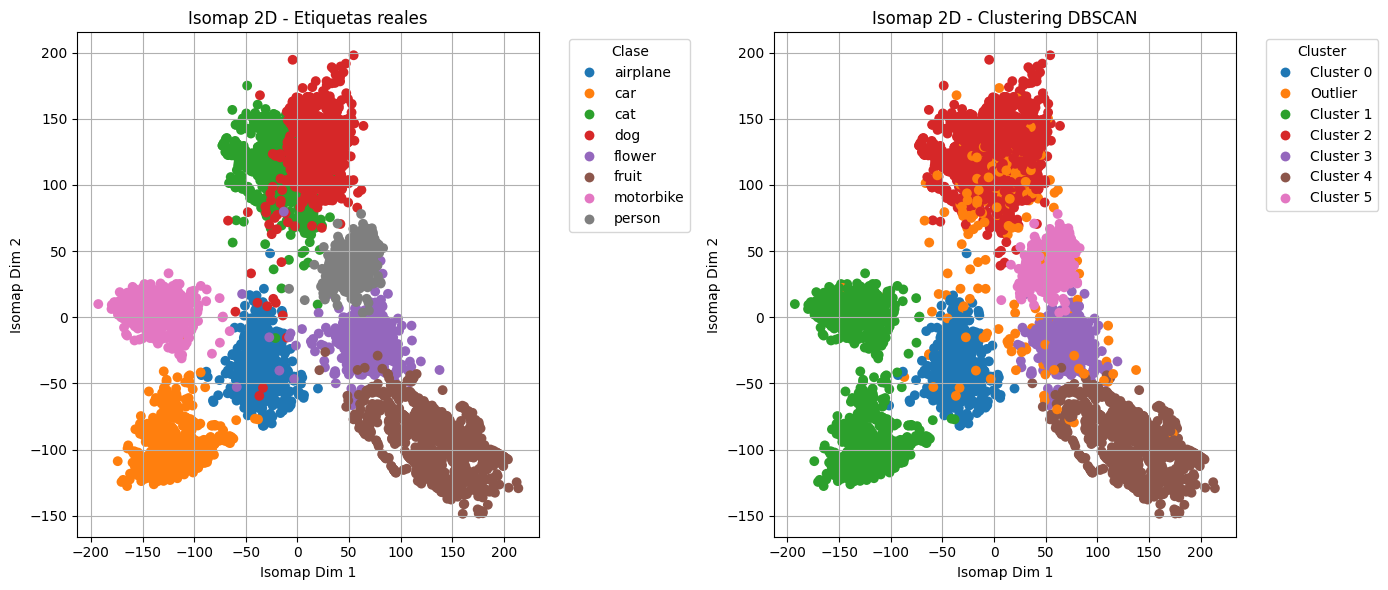

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder

# === 1. Cargar etiquetas reales
df = pd.read_csv(DIR + '/natural_images_labels.csv')
y_true = df['label'].tolist()

# === 2. Codificar etiquetas reales
le = LabelEncoder()
y_true_num = le.fit_transform(y_true)
class_names = le.classes_

# === 3. DBSCAN sobre los datos (no sobre Isomap)
dbscan = DBSCAN(eps=0.4, min_samples=16, metric='cosine')
labels_dbscan = dbscan.fit_predict(X_pca_reducido)

# === 4. Isomap para visualización
X_iso_2d = Isomap(n_components=2, n_neighbors=15).fit_transform(X_pca_reducido)

# === 5. Etiquetas legibles para DBSCAN
labels_str = ['Outlier' if lbl == -1 else f'Cluster {lbl}' for lbl in labels_dbscan]

# === 6. Gráfico comparativo lado a lado
plt.figure(figsize=(14, 6))

# --- (a) Etiquetas reales
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_iso_2d[:, 0], y=X_iso_2d[:, 1],
    hue=y_true, palette='tab10', s=50, edgecolor='none'
)
plt.title("Isomap 2D - Etiquetas reales")
plt.xlabel("Isomap Dim 1")
plt.ylabel("Isomap Dim 2")
plt.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# --- (b) Clustering DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_iso_2d[:, 0], y=X_iso_2d[:, 1],
    hue=labels_str, palette='tab10', s=50, edgecolor='none'
)
plt.title("Isomap 2D - Clustering DBSCAN")
plt.xlabel("Isomap Dim 1")
plt.ylabel("Isomap Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()




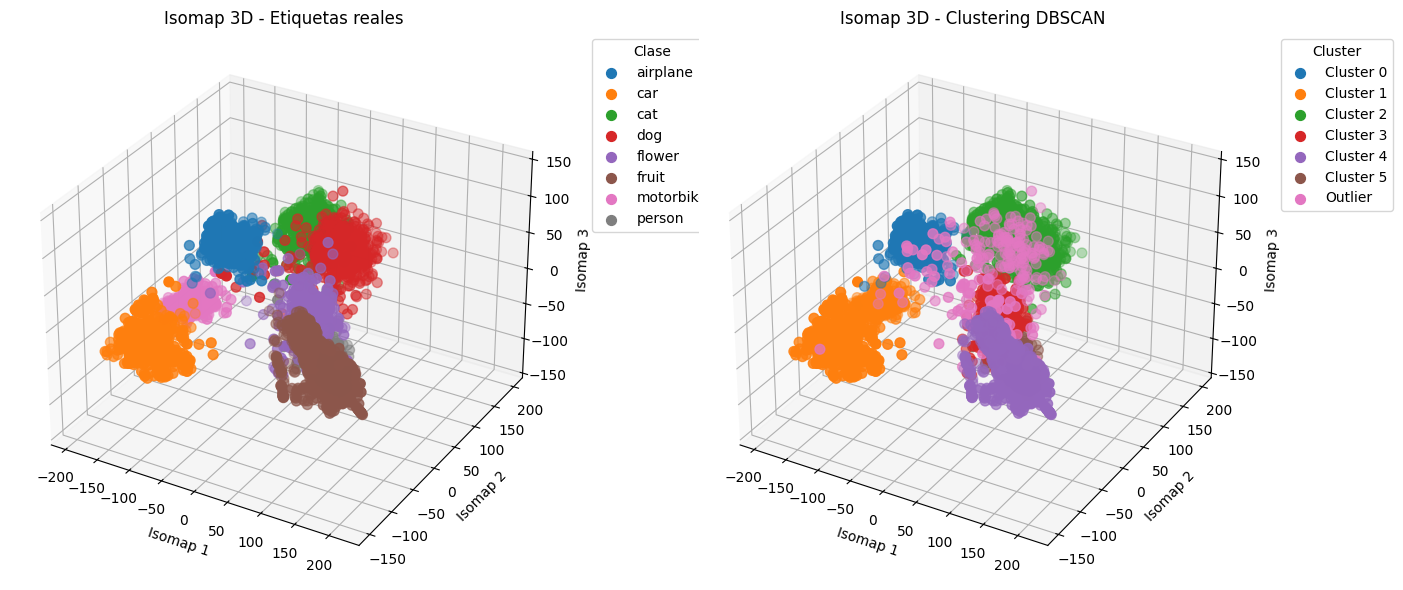

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import Isomap
from sklearn.preprocessing import LabelEncoder

# === 1. Isomap 3D
X_iso_3d = Isomap(n_components=3, n_neighbors=15).fit_transform(X_pca_reducido)

# === 2. Etiquetas reales codificadas
le = LabelEncoder()
y_true_num = le.fit_transform(y_true)
class_names = le.classes_
palette_real = sns.color_palette("tab10", n_colors=len(class_names))
color_dict_real = dict(zip(class_names, palette_real))

# === 3. Etiquetas DBSCAN como strings
labels_str = ['Outlier' if lbl == -1 else f'Cluster {lbl}' for lbl in labels_dbscan]
unique_labels = sorted(set(labels_str))
palette_cluster = sns.color_palette("tab10", n_colors=len(unique_labels))
color_dict_cluster = dict(zip(unique_labels, palette_cluster))

# === 4. Graficar ambos en 3D
fig = plt.figure(figsize=(14, 6))

# --- (a) Etiquetas reales con leyenda
ax1 = fig.add_subplot(121, projection='3d')
for class_label in class_names:
    idx = [i for i, val in enumerate(y_true) if val == class_label]
    ax1.scatter(
        X_iso_3d[idx, 0], X_iso_3d[idx, 1], X_iso_3d[idx, 2],
        label=class_label,
        color=color_dict_real[class_label],
        s=50
    )
ax1.set_title("Isomap 3D - Etiquetas reales")
ax1.set_xlabel("Isomap 1")
ax1.set_ylabel("Isomap 2")
ax1.set_zlabel("Isomap 3")
ax1.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- (b) Clusters DBSCAN con leyenda
ax2 = fig.add_subplot(122, projection='3d')
for label in unique_labels:
    idx = [i for i, val in enumerate(labels_str) if val == label]
    ax2.scatter(
        X_iso_3d[idx, 0], X_iso_3d[idx, 1], X_iso_3d[idx, 2],
        label=label,
        color=color_dict_cluster[label],
        s=50
    )
ax2.set_title("Isomap 3D - Clustering DBSCAN")
ax2.set_xlabel("Isomap 1")
ax2.set_ylabel("Isomap 2")
ax2.set_zlabel("Isomap 3")
ax2.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



## Porque la eleccion

Para esta tarea de agrupamiento de imágenes, se eligieron Clustering Jerárquico y DBSCAN porque capturan distintas formas de organización en los datos, ambas útiles cuando no se conocen las clases de antemano.

El clustering jerárquico fue clave para explorar la estructura general del dataset. Permite ver cómo se relacionan las imágenes entre sí a distintos niveles de similitud, sin necesidad de fijar el número de grupos al inicio. Esto ayuda a descubrir patrones amplios y jerarquías naturales entre categorías visuales.

DBSCAN, por otro lado, se enfocó en detectar agrupamientos más definidos y locales, según la densidad de los datos. Es especialmente valioso para imágenes, ya que puede identificar clusters de forma irregular y distinguir claramente los outliers, que suelen aparecer en datos visuales ruidosos o ambiguos.

Ambos métodos se complementan bien: uno ofrece una visión global y progresiva de las similitudes, y el otro permite encontrar grupos concretos y robustos sin imponer formas o tamaños. Esto enriquece el análisis no supervisado de las imágenes y permite entender mejor cómo se organizan visualmente.

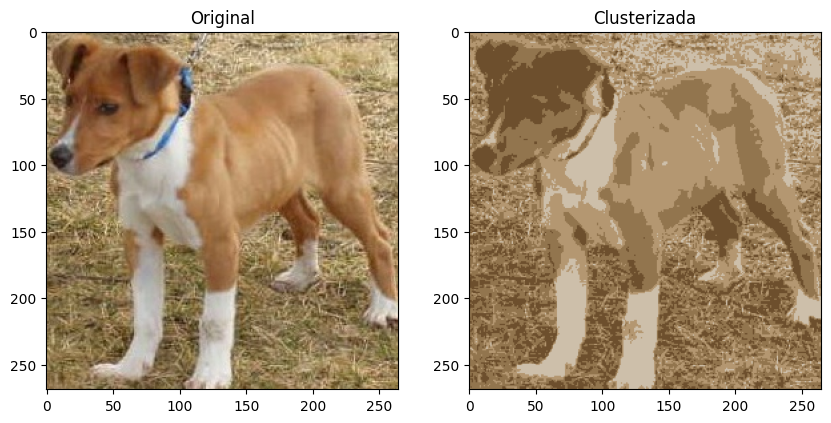

In [3]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Cargar imagen
img = cv2.imread(f'{DIR}/natural_images/dog_0152.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. Convertir imagen a una lista de píxeles
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3. Aplicar K-Means
k = 4  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(pixel_values)
centers = np.uint8(kmeans.cluster_centers_)

# 4. Reconstruir imagen
segmented_img = centers[labels.flatten()]
segmented_img = segmented_img.reshape(img.shape)

# 5. Mostrar resultados
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('Clusterizada')
plt.imshow(segmented_img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..142.0].


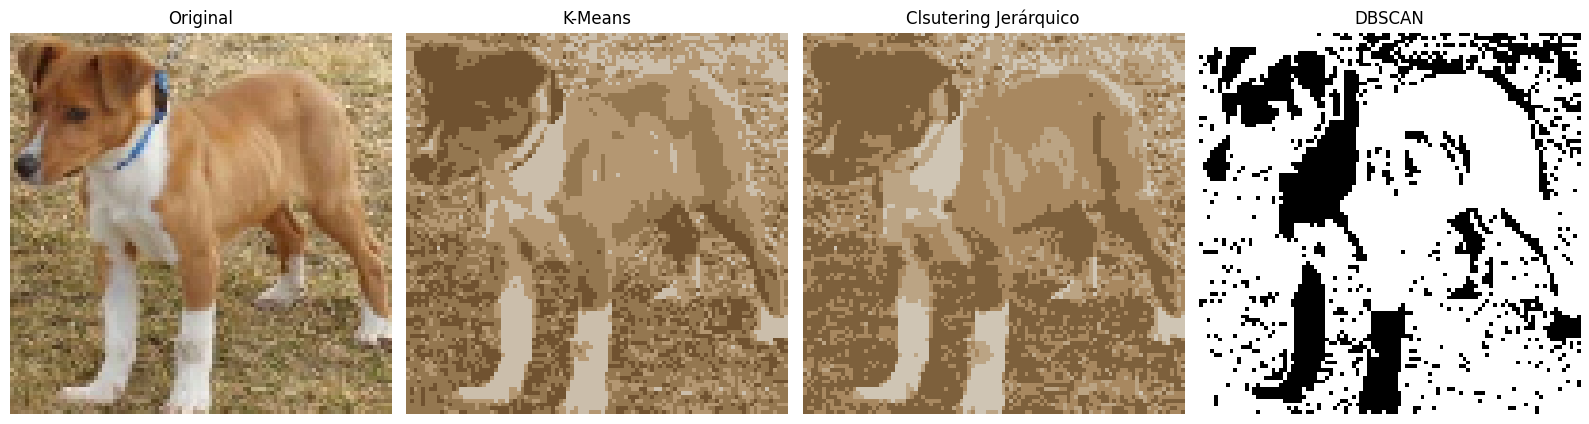

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

# 1. Cargar y redimensionar imagen (¡clave para evitar crashes!)
img = cv2.imread(f'{DIR}/natural_images/dog_0152.jpg')  # cambia por el nombre real
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (100, 100))  # tamaño reducido para evitar kernel crash

original_shape = img.shape
pixel_values = img.reshape((-1, 3)).astype(np.float32)

# 2. K-MEANS
kmeans = KMeans(n_clusters=4, random_state=42)
k_labels = kmeans.fit_predict(pixel_values)
k_centers = np.uint8(kmeans.cluster_centers_)
k_segmented = k_centers[k_labels].reshape(original_shape)

# 3. CLUSTERING JERÁRQUICO
h_clustering = AgglomerativeClustering(n_clusters=4)
h_labels = h_clustering.fit_predict(pixel_values)

# Crear imagen con color promedio por cluster
h_segmented = np.zeros_like(pixel_values)
for label in np.unique(h_labels):
    h_segmented[h_labels == label] = np.mean(pixel_values[h_labels == label], axis=0)
h_segmented = np.uint8(h_segmented.reshape(original_shape))

# 4. DBSCAN (escalamos antes)
scaler = StandardScaler()
pixel_scaled = scaler.fit_transform(pixel_values)

dbscan = DBSCAN(eps=0.5, min_samples=1000)  # puedes ajustar estos valores
db_labels = dbscan.fit_predict(pixel_scaled)

# Asignar color aleatorio a cada cluster
unique_labels = np.unique(db_labels)
colors = np.uint8(np.random.randint(0, 255, size=(len(unique_labels), 3)))

db_segmented = np.zeros_like(pixel_values)
for i, label in enumerate(db_labels):
    if label == -1:
        db_segmented[i] = [0, 0, 0]  # negro para ruido
    else:
        db_segmented[i] = colors[label]

db_segmented = db_segmented.reshape(original_shape)

# 5. Mostrar resultados comparativos
plt.figure(figsize=(16, 8))

titles = ['Original', 'K-Means', 'Clsutering Jerárquico', 'DBSCAN']
images = [img, k_segmented, h_segmented, db_segmented]

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()
